In [3]:
!pip install fredapi
!pip install git+https://github.com/UFM-Market-Trends/UFM-Market-Trends-SDK.git
!pip install fpdf
import ufmtrends_sdk as trends
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
from datetime import datetime
import pytz
import os
with open('DATAWRAPPER_API_TOKEN.txt') as f:
    os.environ["DATAWRAPPER_API_TOKEN"] = f.read()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/UFM-Market-Trends/UFM-Market-Trends-SDK.git to /tmp/pip-req-build-ds3ak7wm
  Running command git clone --filter=blob:none --quiet https://github.com/UFM-Market-Trends/UFM-Market-Trends-SDK.git /tmp/pip-req-build-ds3ak7wm
  Resolved https://github.com/UFM-Market-Trends/UFM-Market-Trends-SDK.git to commit 85829d97a76f98bf4f6b589d15b761e78846635e
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
with open('DATAWRAPPER_API_TOKEN.txt') as f:
    os.environ["DATAWRAPPER_API_TOKEN"] = f.read()
    

with open('FRED_API_KEY.txt') as f:
    os.environ["FRED_API_KEY"] = f.read()
    
fred = Fred(api_key=os.environ["FRED_API_KEY"])

In [5]:
# Not necessary in Vertex AI
# from google.colab import auth
# auth.authenticate_user()

project_id = 'ufm-market-trends'

In [6]:
# https://cloud.google.com/storage/docs/gsutil/commands/cors
# Note that requests to the authenticated browser download endpoint storage.cloud.google.com do not allow CORS requests. 
# For more information about supported endpoints for CORS, see Cloud Storage CORS support.

In [7]:
%%writefile cors.json
[
    {
      "origin": ["https://datawrapper.dwcdn.net/", "http://app.datawrapper.de/"],
      "method": ["GET"],
      "responseHeader": ["Access-Control-Allow-Origin"],
      "maxAgeSeconds": 1
    }
]

Writing cors.json


In [8]:
!gsutil cors set cors.json gs://ufm-market-trends

Setting CORS on gs://ufm-market-trends/...


In [9]:
!gsutil cors get gs://ufm-market-trends

[{"maxAgeSeconds": 1, "method": ["GET"], "origin": ["https://datawrapper.dwcdn.net/", "http://app.datawrapper.de/"], "responseHeader": ["Access-Control-Allow-Origin"]}]


In [10]:
from googleapiclient.discovery import build
gcs_service = build('storage', 'v1')

In [11]:
from googleapiclient.http import MediaFileUpload

def upload_to_cloud_storage(local_name, destination_path=None):
  media = MediaFileUpload(local_name, 
                          mimetype='text/plain',
                          resumable=True)

  request = gcs_service.objects().insert(bucket='ufm-market-trends', 
                                        name=(
                                            destination_path
                                            if destination_path!=None
                                            else "united-states/"+local_name),
                                        media_body=media)

  response = None
  while response is None:
    # _ is a placeholder for a progress object that we ignore.
    # (Our file is small, so we skip reporting progress.)
    _, response = request.next_chunk()

  print('Upload complete')
  print('https://console.cloud.google.com/storage/browser?project={}'.format(project_id))

In [12]:
def get_fred_df(series_name):
  return pd.DataFrame(fred.get_series(series_name))

def get_fred_dict(df, k_periods, function_to_apply):
  fred_dict = {
      'quarters': df[-k_periods::].index,
      'values': function_to_apply(df.iloc[:,0])[-k_periods::]
  }
  return fred_dict

def plot_bar(fred_dict):
  plt.figure(figsize=(20,5))
  plt.bar(fred_dict["quarters"], 
          fred_dict["values"],
          width=50
          )
  plt.show()

def plot_line(fred_dict):
  plt.figure(figsize=(20,5))
  plt.plot(fred_dict["quarters"], 
          fred_dict["values"])
  plt.show()

def write_to_csv(fred_dict, csv_name):

  pd.DataFrame(fred_dict).to_csv(csv_name, index=False)


def process_fred_series(series_name, k_periods, function_to_apply, bar=True, csv_name=None):
  df = get_fred_df(series_name)
  fred_dict = get_fred_dict(df, k_periods, function_to_apply)
  if bar==True:
    plot_bar(fred_dict)
  else:
    plot_line(fred_dict)

  local_name = csv_name if csv_name != None else f"{series_name}.csv"
  write_to_csv(fred_dict, local_name)
  
  upload_to_cloud_storage(local_name,
                          "united-states/fred/"+local_name)

In [13]:
def create_datawrapper_chart(title, type_):
  url = "https://api.datawrapper.de/v3/charts"
  payload = {
      "title": title,
      "type": type_,
      "lastEditStep": 3
  }
  headers = {
      "accept": "*/*",
      "content-type": "application/json",
      "authorization": f"Bearer {os.environ['DATAWRAPPER_API_TOKEN']}"
  } 

  response = requests.post(url, headers=headers, json=payload)

  print("Response: " + str(response.status_code))

  response_object = json.loads(response.text)

  return response_object

In [14]:
def set_datawrapper_chart_properties(chart_id, 
                                     title, chart_type, external_data,
                                     intro, byline, source_name,
                                     source_url,
                                     y_grid_format,
                                     number_divisor,
                                     chart_height=500):
  url = "https://api.datawrapper.de/v3/charts/" + chart_id

  payload = {
      "title": title,
      "type": chart_type,
      "lastEditStep": 3,
      "externalData": f"https://static.dwcdn.net/data/{chart_id}.csv",
      "metadata": {
          "publish": {
              "chart-height": chart_height,
          },
          "data": {
              "external-data": external_data,
              "upload-method": "external-data",
              "use-datawrapper-cdn": True,
              "column-format": 
                {'values': 
                { 'number-divisor': number_divisor}
                },
          },
            "describe": {
              "intro": intro,
              "byline": byline,
              "source-name": source_name,
              "source-url": source_url,
          },
          "annotate": {
              "notes": f"Last update: {datetime.now(pytz.timezone('US/Central')).strftime('%d/%m/%Y %H:%M:%S')}"
          },
          "visualize": {
              "valueLabels": {
                  "show": "always"
              },
              'y-grid-format': y_grid_format
          }
      }
  }

  headers = {
      "accept": "*/*",
      "content-type": "application/json",
      "authorization": f"Bearer {os.environ['DATAWRAPPER_API_TOKEN']}"
  }

  response = requests.put(url, headers=headers, json=payload)

  print("Response: "+ str(response.status_code))

  response_object = json.loads(response.text)

  return response_object

In [15]:
def publish_datawrapper_chart(chart_id):
  response = requests.post(f"https://api.datawrapper.de/v3/charts/{chart_id}/publish", 
                           headers={
                               "authorization": f"Bearer {os.environ['DATAWRAPPER_API_TOKEN']}"
                               })
  
  print({"Response: " + str(response.status_code)})

  response_object = json.loads(response.text)

  print(f"Sharing url: https://www.datawrapper.de/_/{chart_id}/")
  
  return response_object

# ECONOMIC ACTIVITY

## Real GDP

https://fred.stlouisfed.org/categories/106

https://fred.stlouisfed.org/series/GDPC1

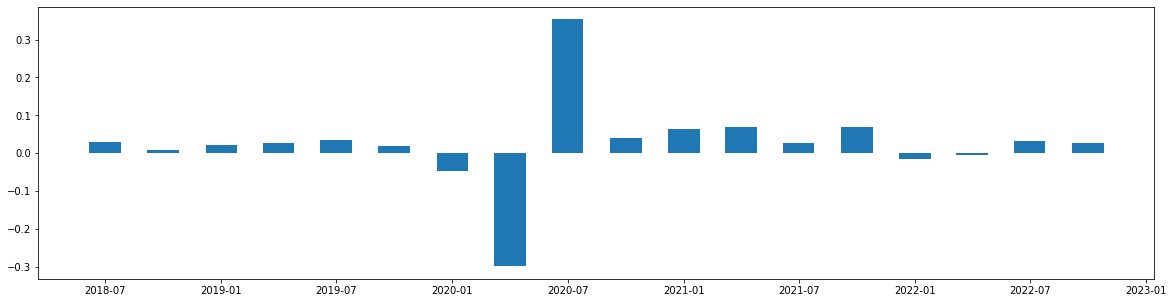

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends


In [16]:
process_fred_series(series_name="GDPC1",
                    k_periods=18,
                    function_to_apply= lambda values: np.array(trends.get_preceding_quarter_annualized_variation(values)),
                    bar=True)

### GDPC1 Chart ID: EbLbc

In [17]:
set_datawrapper_chart_properties(chart_id="EbLbc", 
                                  title="Real Gross Domestic Product (GDP)", 
                                  chart_type="column-chart", 
                                  external_data="https://storage.googleapis.com/ufm-market-trends/united-states/fred/GDPC1.csv",
                                  intro="Percent Change from Preceding Period, Seasonally Adjusted Annual Rate.", 
                                  byline="UFM Market Trends", 
                                  source_name="U.S. Bureau of Economic Analysis",
                                  source_url="https://fred.stlouisfed.org/series/A191RL1Q225SBEA",
                                  y_grid_format="0.0%",
                                  number_divisor=-2)

Response: 200


{'publicId': 'EbLbc',
 'language': 'en-US',
 'theme': 'datawrapper-data',
 'id': 'EbLbc',
 'type': 'column-chart',
 'title': 'Real Gross Domestic Product (GDP)',
 'lastEditStep': 3,
 'publishedAt': '2023-02-26T18:55:33.000Z',
 'publicUrl': 'https://datawrapper.dwcdn.net/EbLbc/84/',
 'publicVersion': 84,
 'deleted': False,
 'deletedAt': None,
 'forkable': False,
 'isFork': False,
 'metadata': {'data': {'changes': [],
   'transpose': False,
   'vertical-header': True,
   'horizontal-header': True,
   'column-format': {'values': {'number-divisor': -2}},
   'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/GDPC1.csv',
   'upload-method': 'external-data',
   'use-datawrapper-cdn': True},
  'describe': {'source-name': 'U.S. Bureau of Economic Analysis',
   'source-url': 'https://fred.stlouisfed.org/series/A191RL1Q225SBEA',
   'intro': 'Percent Change from Preceding Period, Seasonally Adjusted Annual Rate.',
   'byline': 'UFM Market Trends',
   'aria-descri

In [18]:
publish_datawrapper_chart(chart_id="EbLbc")

{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/EbLbc/


{'data': {'publicId': 'EbLbc',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'EbLbc',
  'type': 'column-chart',
  'title': 'Real Gross Domestic Product (GDP)',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:34:01.897Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/EbLbc/85/',
  'publicVersion': 85,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': -2}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/GDPC1.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'U.S. Bureau of Economic Analysis',
    'source-url': 'https://fred.stlouisfed.org/series/A191RL1Q225SBEA',
    'intro': 'Percent Change from Preceding Period, Seasonally Adjusted Annual Rate.',
    'byline': 'U

##  Gross Output by Industry: All Industries (GOAI)	

https://fred.stlouisfed.org/tags/series?t=gross%3Boutput

https://fred.stlouisfed.org/series/GOAI


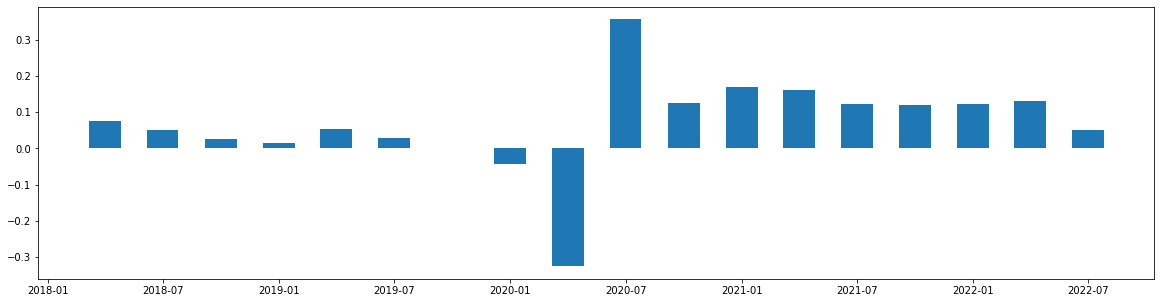

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends


In [19]:
process_fred_series(series_name="GOAI",
                    k_periods=18,
                    function_to_apply= lambda values: np.array(trends.get_preceding_quarter_annualized_variation(values)),
                    bar=True)

In [20]:
# create_datawrapper_chart("Real Gross Output (GO)", type_="column-chart")

### GOAI Chart ID: CmAvD

In [21]:
set_datawrapper_chart_properties(chart_id="CmAvD", 
                                  title="Real Gross Output (GO)", 
                                  chart_type="column-chart", 
                                  external_data="https://storage.googleapis.com/ufm-market-trends/united-states/fred/GOAI.csv",
                                  intro="Percent Change from Preceding Period, Seasonally Adjusted Annual Rate.", 
                                  byline="UFM Market Trends", 
                                  source_name="U.S. Bureau of Economic Analysis",
                                  source_url="https://fred.stlouisfed.org/series/GOAI",
                                  y_grid_format="0.0%",
                                 number_divisor=-2)

Response: 200


{'publicId': 'CmAvD',
 'language': 'en-US',
 'theme': 'datawrapper-data',
 'id': 'CmAvD',
 'type': 'column-chart',
 'title': 'Real Gross Output (GO)',
 'lastEditStep': 3,
 'publishedAt': '2023-02-26T18:55:37.000Z',
 'publicUrl': 'https://datawrapper.dwcdn.net/CmAvD/15/',
 'publicVersion': 15,
 'deleted': False,
 'deletedAt': None,
 'forkable': False,
 'isFork': False,
 'metadata': {'data': {'changes': [],
   'transpose': False,
   'vertical-header': True,
   'horizontal-header': True,
   'column-format': {'values': {'number-divisor': -2}},
   'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/GOAI.csv',
   'upload-method': 'external-data',
   'use-datawrapper-cdn': True},
  'describe': {'source-name': 'U.S. Bureau of Economic Analysis',
   'source-url': 'https://fred.stlouisfed.org/series/GOAI',
   'intro': 'Percent Change from Preceding Period, Seasonally Adjusted Annual Rate.',
   'byline': 'UFM Market Trends',
   'aria-description': '',
   'number-

In [22]:
publish_datawrapper_chart(chart_id="CmAvD")

{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/CmAvD/


{'data': {'publicId': 'CmAvD',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'CmAvD',
  'type': 'column-chart',
  'title': 'Real Gross Output (GO)',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:34:05.486Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/CmAvD/16/',
  'publicVersion': 16,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': -2}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/GOAI.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'U.S. Bureau of Economic Analysis',
    'source-url': 'https://fred.stlouisfed.org/series/GOAI',
    'intro': 'Percent Change from Preceding Period, Seasonally Adjusted Annual Rate.',
    'byline': 'UFM Market Trends',
    

## Industrial Production Index (IPI)

https://fred.stlouisfed.org/series/INDPRO

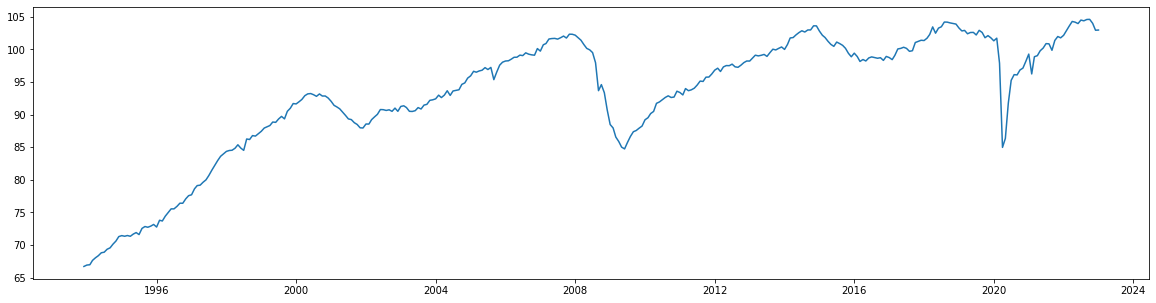

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends


In [23]:
process_fred_series(series_name="INDPRO",
                    k_periods=350,
                    function_to_apply= lambda values: values,
                    bar=False)

In [24]:
# create_datawrapper_chart("Industrial Production Index (IPI)", type_="d3-lines")

### Chart ID: LtWGs

In [25]:
set_datawrapper_chart_properties(chart_id="LtWGs", 
                                  title="Industrial Production Index (IPI)", 
                                  chart_type="d3-lines", 
                                  external_data="https://storage.googleapis.com/ufm-market-trends/united-states/fred/INDPRO.csv",
                                  intro="Index 2017=100, Seasonally Adjusted.", 
                                  byline="UFM Market Trends", 
                                  source_name="St. Louis Fed",
                                  source_url="https://fred.stlouisfed.org/series/INDPRO",
                                  y_grid_format="",
                                 number_divisor=0)

Response: 200


{'publicId': 'LtWGs',
 'language': 'en-US',
 'theme': 'datawrapper-data',
 'id': 'LtWGs',
 'type': 'd3-lines',
 'title': 'Industrial Production Index (IPI)',
 'lastEditStep': 3,
 'publishedAt': '2023-02-26T18:55:41.000Z',
 'publicUrl': 'https://datawrapper.dwcdn.net/LtWGs/17/',
 'publicVersion': 17,
 'deleted': False,
 'deletedAt': None,
 'forkable': False,
 'isFork': False,
 'metadata': {'data': {'changes': [],
   'transpose': False,
   'vertical-header': True,
   'horizontal-header': True,
   'column-format': {'values': {'number-divisor': 0}},
   'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/INDPRO.csv',
   'upload-method': 'external-data',
   'use-datawrapper-cdn': True},
  'describe': {'source-name': 'St. Louis Fed',
   'source-url': 'https://fred.stlouisfed.org/series/INDPRO',
   'intro': 'Index 2017=100, Seasonally Adjusted.',
   'byline': 'UFM Market Trends',
   'aria-description': '',
   'number-format': '-',
   'number-divisor': 0,
   'n

In [26]:
publish_datawrapper_chart(chart_id="LtWGs")

{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/LtWGs/


{'data': {'publicId': 'LtWGs',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'LtWGs',
  'type': 'd3-lines',
  'title': 'Industrial Production Index (IPI)',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:34:09.649Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/LtWGs/18/',
  'publicVersion': 18,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/INDPRO.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'St. Louis Fed',
    'source-url': 'https://fred.stlouisfed.org/series/INDPRO',
    'intro': 'Index 2017=100, Seasonally Adjusted.',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'number-format'

## Domestic + Foreign Auto Sales

https://fred.stlouisfed.org/series/LAUTOSA

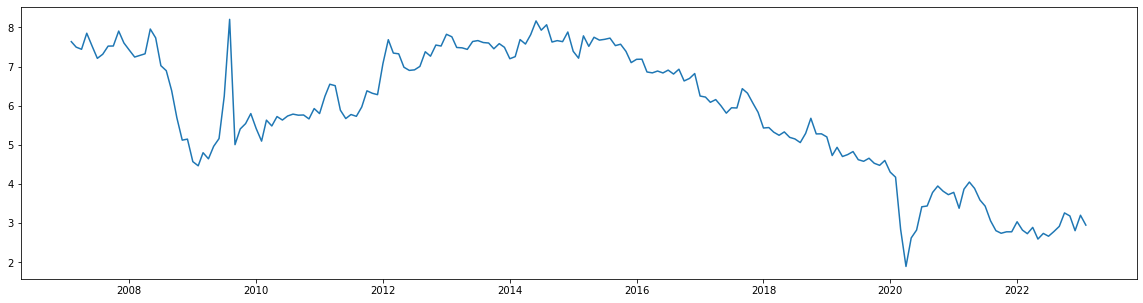

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends


In [27]:
process_fred_series(series_name="LAUTOSA",
                    k_periods=193,
                    function_to_apply= lambda values: values,
                    bar=False)

In [28]:
# create_datawrapper_chart("Domestic + Foreign Auto Sales", type_="d3-lines")

### Chart ID:  v2IXl

In [29]:
set_datawrapper_chart_properties(chart_id="v2IXl", 
                                  title="Domestic + Foreign Auto Sales", 
                                  chart_type="d3-lines", 
                                  external_data="https://storage.googleapis.com/ufm-market-trends/united-states/fred/LAUTOSA.csv",
                                  intro="Millions of Units, Seasonally Adjusted Annual Rate.", 
                                  byline="UFM Market Trends", 
                                  source_name="St. Louis Fed",
                                  source_url="https://fred.stlouisfed.org/series/LAUTOSA",
                                  y_grid_format="",
                                 number_divisor=0)

Response: 200


{'publicId': 'v2IXl',
 'language': 'en-US',
 'theme': 'datawrapper-data',
 'id': 'v2IXl',
 'type': 'd3-lines',
 'title': 'Domestic + Foreign Auto Sales',
 'lastEditStep': 3,
 'publishedAt': '2023-02-26T18:55:44.000Z',
 'publicUrl': 'https://datawrapper.dwcdn.net/v2IXl/17/',
 'publicVersion': 17,
 'deleted': False,
 'deletedAt': None,
 'forkable': False,
 'isFork': False,
 'metadata': {'data': {'changes': [],
   'transpose': False,
   'vertical-header': True,
   'horizontal-header': True,
   'column-format': {'values': {'number-divisor': 0}},
   'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/LAUTOSA.csv',
   'upload-method': 'external-data',
   'use-datawrapper-cdn': True},
  'describe': {'source-name': 'St. Louis Fed',
   'source-url': 'https://fred.stlouisfed.org/series/LAUTOSA',
   'intro': 'Millions of Units, Seasonally Adjusted Annual Rate.',
   'byline': 'UFM Market Trends',
   'aria-description': '',
   'number-format': '-',
   'number-divis

In [30]:
publish_datawrapper_chart(chart_id="v2IXl")

{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/v2IXl/


{'data': {'publicId': 'v2IXl',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'v2IXl',
  'type': 'd3-lines',
  'title': 'Domestic + Foreign Auto Sales',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:34:13.840Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/v2IXl/18/',
  'publicVersion': 18,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/LAUTOSA.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'St. Louis Fed',
    'source-url': 'https://fred.stlouisfed.org/series/LAUTOSA',
    'intro': 'Millions of Units, Seasonally Adjusted Annual Rate.',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'n

## Housing and building permits


https://fred.stlouisfed.org/series/PERMIT

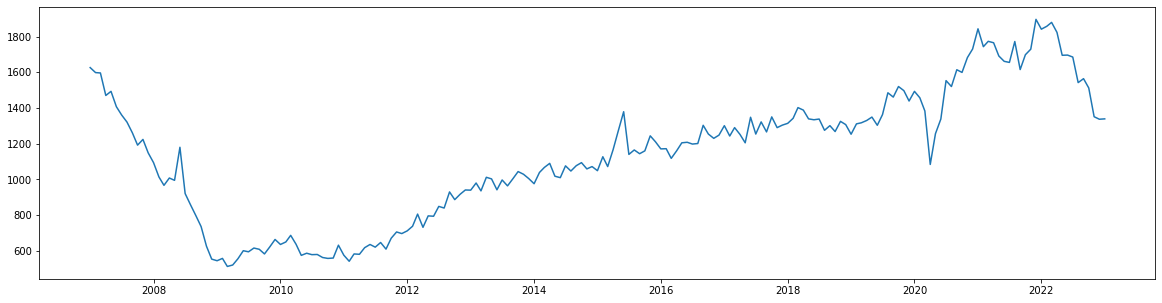

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends


In [31]:
process_fred_series(series_name="PERMIT",
                    k_periods=193,
                    function_to_apply= lambda values: values,
                    bar=False)

In [32]:
# create_datawrapper_chart("Building permits", type_="d3-lines")

## Chart ID: 4avor

In [33]:
set_datawrapper_chart_properties(chart_id="4avor", 
                                  title="Building Permits", 
                                  chart_type="d3-lines", 
                                  external_data="https://storage.googleapis.com/ufm-market-trends/united-states/fred/PERMIT.csv",
                                  intro="Thousands of Units, Seasonally Adjusted Annual Rate.", 
                                  byline="UFM Market Trends", 
                                  source_name="St. Louis Fed",
                                  source_url="https://fred.stlouisfed.org/series/PERMIT",
                                  y_grid_format="",
                                 number_divisor=0)

Response: 200


{'publicId': '4avor',
 'language': 'en-US',
 'theme': 'datawrapper-data',
 'id': '4avor',
 'type': 'd3-lines',
 'title': 'Building Permits',
 'lastEditStep': 3,
 'publishedAt': '2023-02-26T18:55:49.000Z',
 'publicUrl': 'https://datawrapper.dwcdn.net/4avor/6/',
 'publicVersion': 6,
 'deleted': False,
 'deletedAt': None,
 'forkable': False,
 'isFork': False,
 'metadata': {'data': {'changes': [],
   'transpose': False,
   'vertical-header': True,
   'horizontal-header': True,
   'column-format': {'values': {'number-divisor': 0}},
   'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/PERMIT.csv',
   'upload-method': 'external-data',
   'use-datawrapper-cdn': True},
  'describe': {'source-name': 'St. Louis Fed',
   'source-url': 'https://fred.stlouisfed.org/series/PERMIT',
   'intro': 'Thousands of Units, Seasonally Adjusted Annual Rate.',
   'byline': 'UFM Market Trends',
   'aria-description': '',
   'number-format': '-',
   'number-divisor': 0,
   'numb

In [34]:
publish_datawrapper_chart(chart_id="4avor")

{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/4avor/


{'data': {'publicId': '4avor',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': '4avor',
  'type': 'd3-lines',
  'title': 'Building Permits',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:34:17.330Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/4avor/7/',
  'publicVersion': 7,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/PERMIT.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'St. Louis Fed',
    'source-url': 'https://fred.stlouisfed.org/series/PERMIT',
    'intro': 'Thousands of Units, Seasonally Adjusted Annual Rate.',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'number-format': '

## Domestic auto inventories

https://fred.stlouisfed.org/series/AUINSA

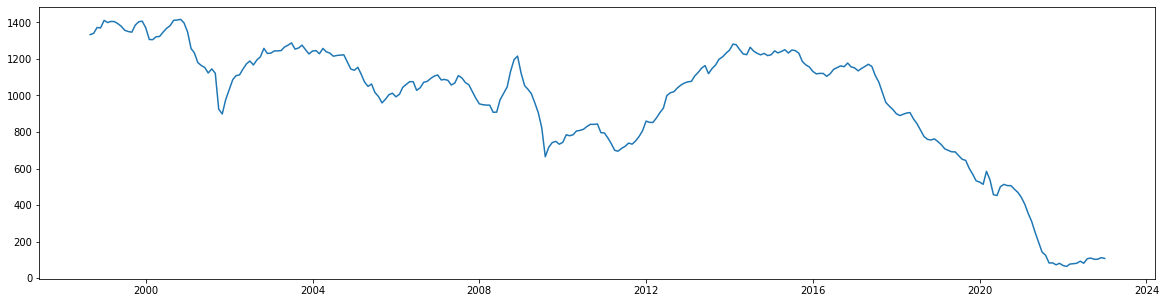

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends


In [35]:
process_fred_series(series_name="AUINSA",
                    k_periods=293,
                    function_to_apply= lambda values: values,
                    bar=False)

In [36]:
# create_datawrapper_chart("Domestic Auto Inventories", type_="d3-lines")

## Chart ID: fkaMa

In [37]:
set_datawrapper_chart_properties(chart_id="fkaMa", 
                                  title="Domestic Auto Inventories", 
                                  chart_type="d3-lines", 
                                  external_data="https://storage.googleapis.com/ufm-market-trends/united-states/fred/AUINSA.csv",
                                  intro="Thousands of Units, Seasonally Adjusted.", 
                                  byline="UFM Market Trends", 
                                  source_name="St. Louis Fed",
                                  source_url="https://fred.stlouisfed.org/series/AUINSA",
                                  y_grid_format="",
                                  number_divisor=0,
                                  chart_height=250)

Response: 200


{'publicId': 'fkaMa',
 'language': 'en-US',
 'theme': 'datawrapper-data',
 'id': 'fkaMa',
 'type': 'd3-lines',
 'title': 'Domestic Auto Inventories',
 'lastEditStep': 3,
 'publishedAt': '2023-02-26T18:55:52.000Z',
 'publicUrl': 'https://datawrapper.dwcdn.net/fkaMa/5/',
 'publicVersion': 5,
 'deleted': False,
 'deletedAt': None,
 'forkable': False,
 'isFork': False,
 'metadata': {'data': {'changes': [],
   'transpose': False,
   'vertical-header': True,
   'horizontal-header': True,
   'column-format': {'values': {'number-divisor': 0}},
   'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/AUINSA.csv',
   'upload-method': 'external-data',
   'use-datawrapper-cdn': True},
  'describe': {'source-name': 'St. Louis Fed',
   'source-url': 'https://fred.stlouisfed.org/series/AUINSA',
   'intro': 'Thousands of Units, Seasonally Adjusted.',
   'byline': 'UFM Market Trends',
   'aria-description': '',
   'number-format': '-',
   'number-divisor': 0,
   'number-

In [38]:
publish_datawrapper_chart(chart_id="fkaMa")

{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/fkaMa/


{'data': {'publicId': 'fkaMa',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'fkaMa',
  'type': 'd3-lines',
  'title': 'Domestic Auto Inventories',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:34:21.613Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/fkaMa/6/',
  'publicVersion': 6,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/AUINSA.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'St. Louis Fed',
    'source-url': 'https://fred.stlouisfed.org/series/AUINSA',
    'intro': 'Thousands of Units, Seasonally Adjusted.',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'number-format': '-',

## Auto inventory Sales ratio

https://fred.stlouisfed.org/series/AISRSA

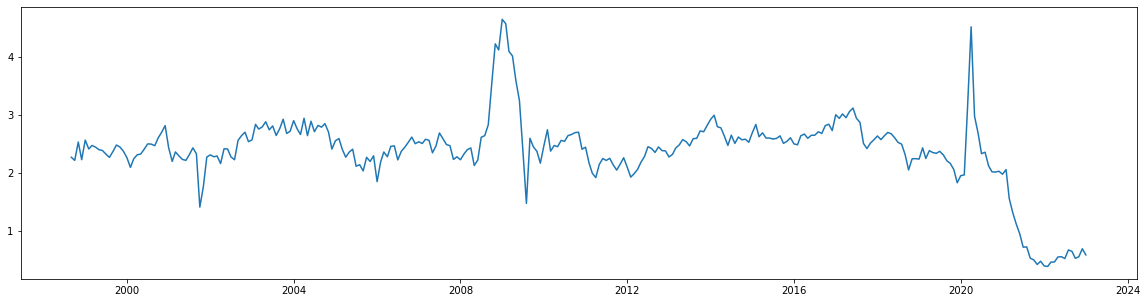

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends


In [39]:
process_fred_series(series_name="AISRSA",
                    k_periods=293,
                    function_to_apply= lambda values: values,
                    bar=False)

In [40]:
# create_datawrapper_chart("Auto Inventory/Sales Ratio", type_="d3-lines")


### Chart ID: DfB27

In [41]:
set_datawrapper_chart_properties(chart_id="DfB27", 
                                  title="Auto Inventory/Sales Ratio", 
                                  chart_type="d3-lines", 
                                  external_data="https://storage.googleapis.com/ufm-market-trends/united-states/fred/AISRSA.csv",
                                  intro="Ratio, Seasonally Adjusted.", 
                                  byline="UFM Market Trends", 
                                  source_name="St. Louis Fed",
                                  source_url="https://fred.stlouisfed.org/series/AISRSA",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=250)

Response: 200


{'publicId': 'DfB27',
 'language': 'en-US',
 'theme': 'datawrapper-data',
 'id': 'DfB27',
 'type': 'd3-lines',
 'title': 'Auto Inventory/Sales Ratio',
 'lastEditStep': 3,
 'publishedAt': '2023-02-26T18:55:55.000Z',
 'publicUrl': 'https://datawrapper.dwcdn.net/DfB27/5/',
 'publicVersion': 5,
 'deleted': False,
 'deletedAt': None,
 'forkable': False,
 'isFork': False,
 'metadata': {'data': {'changes': [],
   'transpose': False,
   'vertical-header': True,
   'horizontal-header': True,
   'column-format': {'values': {'number-divisor': 0}},
   'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/AISRSA.csv',
   'upload-method': 'external-data',
   'use-datawrapper-cdn': True},
  'describe': {'source-name': 'St. Louis Fed',
   'source-url': 'https://fred.stlouisfed.org/series/AISRSA',
   'intro': 'Ratio, Seasonally Adjusted.',
   'byline': 'UFM Market Trends',
   'aria-description': '',
   'number-format': '-',
   'number-divisor': 0,
   'number-append': '',

In [42]:
publish_datawrapper_chart(chart_id="DfB27")

{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/DfB27/


{'data': {'publicId': 'DfB27',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'DfB27',
  'type': 'd3-lines',
  'title': 'Auto Inventory/Sales Ratio',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:34:25.479Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/DfB27/6/',
  'publicVersion': 6,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/AISRSA.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'St. Louis Fed',
    'source-url': 'https://fred.stlouisfed.org/series/AISRSA',
    'intro': 'Ratio, Seasonally Adjusted.',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'number-format': '-',
    'number

## Total vehicle sales 

https://fred.stlouisfed.org/series/TOTALSA

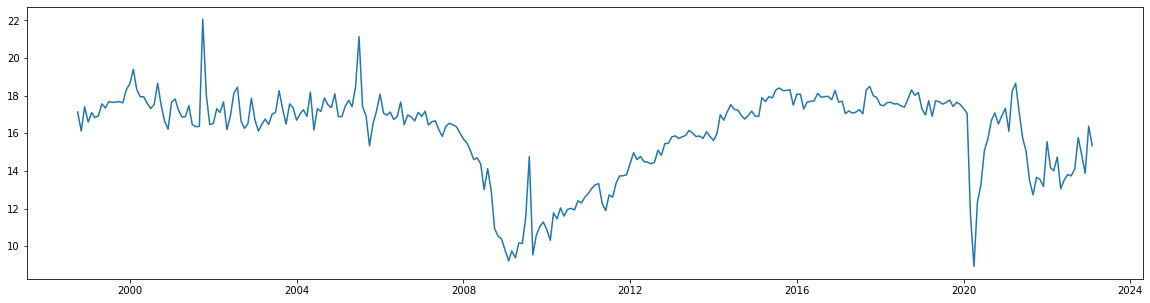

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends


In [43]:
process_fred_series(series_name="TOTALSA",
                    k_periods=293,
                    function_to_apply= lambda values: values,
                    bar=False)

In [44]:
# create_datawrapper_chart("Total Vehicle Sales", type_="d3-lines")

### Chart ID: 3FVph

In [45]:
set_datawrapper_chart_properties(chart_id="3FVph", 
                                  title="Total Vehicle Sales", 
                                  chart_type="d3-lines", 
                                  external_data="https://storage.googleapis.com/ufm-market-trends/united-states/fred/TOTALSA.csv",
                                  intro="Millions of Units, Seasonally Adjusted Annual Rate.", 
                                  byline="UFM Market Trends", 
                                  source_name="St. Louis Fed",
                                  source_url="https://fred.stlouisfed.org/series/TOTALSA",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=250)

Response: 200


{'publicId': '3FVph',
 'language': 'en-US',
 'theme': 'datawrapper-data',
 'id': '3FVph',
 'type': 'd3-lines',
 'title': 'Total Vehicle Sales',
 'lastEditStep': 3,
 'publishedAt': '2023-02-26T18:55:59.000Z',
 'publicUrl': 'https://datawrapper.dwcdn.net/3FVph/4/',
 'publicVersion': 4,
 'deleted': False,
 'deletedAt': None,
 'forkable': False,
 'isFork': False,
 'metadata': {'data': {'changes': [],
   'transpose': False,
   'vertical-header': True,
   'horizontal-header': True,
   'column-format': {'values': {'number-divisor': 0}},
   'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/TOTALSA.csv',
   'upload-method': 'external-data',
   'use-datawrapper-cdn': True},
  'describe': {'source-name': 'St. Louis Fed',
   'source-url': 'https://fred.stlouisfed.org/series/TOTALSA',
   'intro': 'Millions of Units, Seasonally Adjusted Annual Rate.',
   'byline': 'UFM Market Trends',
   'aria-description': '',
   'number-format': '-',
   'number-divisor': 0,
   '

In [46]:
publish_datawrapper_chart(chart_id="3FVph")

{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/3FVph/


{'data': {'publicId': '3FVph',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': '3FVph',
  'type': 'd3-lines',
  'title': 'Total Vehicle Sales',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:34:29.401Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/3FVph/5/',
  'publicVersion': 5,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/TOTALSA.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'St. Louis Fed',
    'source-url': 'https://fred.stlouisfed.org/series/TOTALSA',
    'intro': 'Millions of Units, Seasonally Adjusted Annual Rate.',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'number-format

# LABOR MARKET

## Unemployment rate

https://fred.stlouisfed.org/series/UNRATE

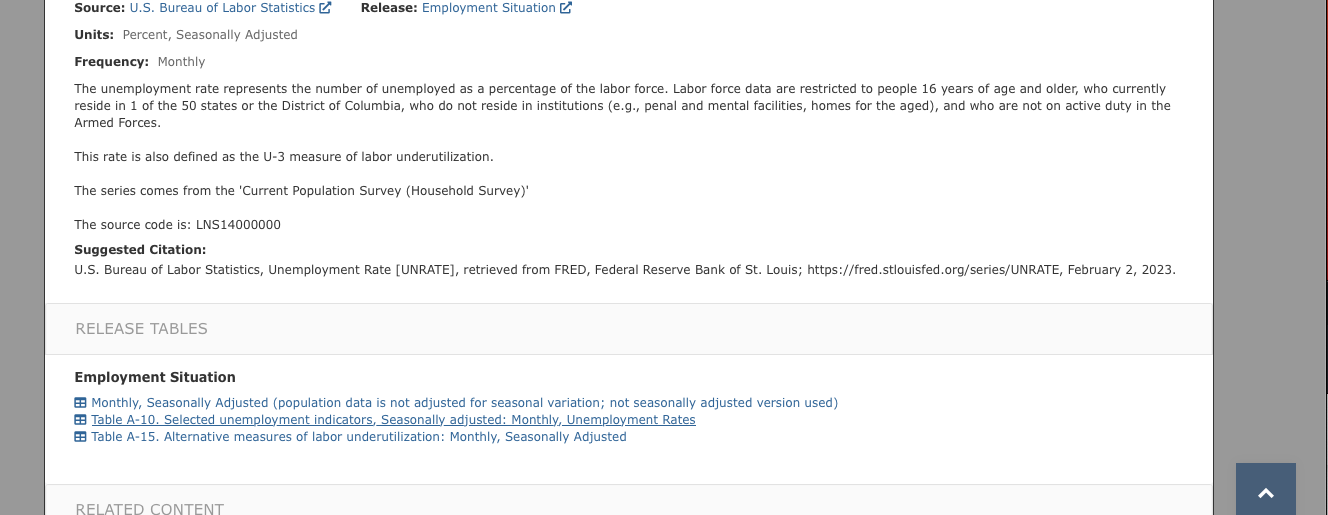

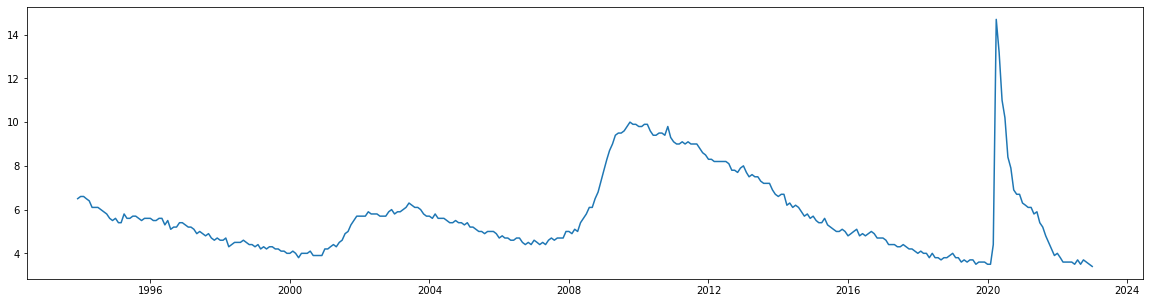

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends


In [47]:
process_fred_series(series_name="UNRATE",
                    k_periods=350,
                    function_to_apply= lambda values: values,
                    bar=False)

In [48]:
# create_datawrapper_chart("Unemployment Rate", type_="d3-lines")

### Chart ID: q7Opu

In [49]:
set_datawrapper_chart_properties(chart_id="q7Opu", 
                                  title="Unemployment Rate", 
                                  chart_type="d3-lines", 
                                  external_data="https://storage.googleapis.com/ufm-market-trends/united-states/fred/UNRATE.csv",
                                  intro="Percent, Seasonally Adjusted.", 
                                  byline="UFM Market Trends", 
                                  source_name="St. Louis Fed",
                                  source_url="https://fred.stlouisfed.org/series/UNRATE",
                                  y_grid_format="0.0%",
                                  number_divisor=0)

Response: 200


{'publicId': 'q7Opu',
 'language': 'en-US',
 'theme': 'datawrapper-data',
 'id': 'q7Opu',
 'type': 'd3-lines',
 'title': 'Unemployment Rate',
 'lastEditStep': 3,
 'publishedAt': '2023-02-26T18:56:03.000Z',
 'publicUrl': 'https://datawrapper.dwcdn.net/q7Opu/4/',
 'publicVersion': 4,
 'deleted': False,
 'deletedAt': None,
 'forkable': False,
 'isFork': False,
 'metadata': {'data': {'changes': [],
   'transpose': False,
   'vertical-header': True,
   'horizontal-header': True,
   'column-format': {'values': {'number-divisor': 0}},
   'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/UNRATE.csv',
   'upload-method': 'external-data',
   'use-datawrapper-cdn': True},
  'describe': {'source-name': 'St. Louis Fed',
   'source-url': 'https://fred.stlouisfed.org/series/UNRATE',
   'intro': 'Percent, Seasonally Adjusted.',
   'byline': 'UFM Market Trends',
   'aria-description': '',
   'number-format': '-',
   'number-divisor': 0,
   'number-append': '',
   'nu

In [50]:
publish_datawrapper_chart(chart_id="q7Opu")

{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/q7Opu/


{'data': {'publicId': 'q7Opu',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'q7Opu',
  'type': 'd3-lines',
  'title': 'Unemployment Rate',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:34:33.170Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/q7Opu/5/',
  'publicVersion': 5,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/UNRATE.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'St. Louis Fed',
    'source-url': 'https://fred.stlouisfed.org/series/UNRATE',
    'intro': 'Percent, Seasonally Adjusted.',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'number-format': '-',
    'number-diviso

## Initial Weekly jobless claims

https://fred.stlouisfed.org/series/ICSA

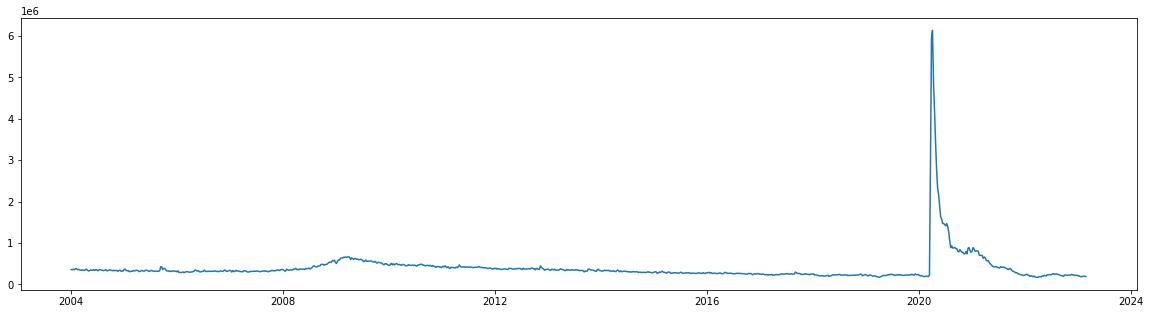

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends


In [51]:
process_fred_series(series_name="ICSA",
                    k_periods=1000,
                    function_to_apply= lambda values: values,
                    bar=False)

In [52]:
# create_datawrapper_chart("Initial Weekly Jobless Claims", type_="d3-lines")

### Chart ID: uMzLY

In [53]:
set_datawrapper_chart_properties(chart_id="uMzLY", 
                                  title="Initial Weekly Jobless Claims", 
                                  chart_type="d3-lines", 
                                  external_data="https://storage.googleapis.com/ufm-market-trends/united-states/fred/ICSA.csv",
                                  intro="Thousands of Units, Seasonally Adjusted.", 
                                  byline="UFM Market Trends", 
                                  source_name="St. Louis Fed",
                                  source_url="https://fred.stlouisfed.org/series/ICSA",
                                  y_grid_format="",
                                  number_divisor=0)

Response: 200


{'publicId': 'uMzLY',
 'language': 'en-US',
 'theme': 'datawrapper-data',
 'id': 'uMzLY',
 'type': 'd3-lines',
 'title': 'Initial Weekly Jobless Claims',
 'lastEditStep': 3,
 'publishedAt': '2023-02-26T18:56:07.000Z',
 'publicUrl': 'https://datawrapper.dwcdn.net/uMzLY/3/',
 'publicVersion': 3,
 'deleted': False,
 'deletedAt': None,
 'forkable': False,
 'isFork': False,
 'metadata': {'data': {'changes': [],
   'transpose': False,
   'vertical-header': True,
   'horizontal-header': True,
   'column-format': {'values': {'number-divisor': 0}},
   'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/ICSA.csv',
   'upload-method': 'external-data',
   'use-datawrapper-cdn': True},
  'describe': {'source-name': 'St. Louis Fed',
   'source-url': 'https://fred.stlouisfed.org/series/ICSA',
   'intro': 'Thousands of Units, Seasonally Adjusted.',
   'byline': 'UFM Market Trends',
   'aria-description': '',
   'number-format': '-',
   'number-divisor': 0,
   'number-

In [54]:
publish_datawrapper_chart(chart_id="uMzLY")

{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/uMzLY/


{'data': {'publicId': 'uMzLY',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'uMzLY',
  'type': 'd3-lines',
  'title': 'Initial Weekly Jobless Claims',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:34:37.868Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/uMzLY/4/',
  'publicVersion': 4,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/ICSA.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'St. Louis Fed',
    'source-url': 'https://fred.stlouisfed.org/series/ICSA',
    'intro': 'Thousands of Units, Seasonally Adjusted.',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'number-format': '-',

# INFLATION NAD PRICES

## M1

https://fred.stlouisfed.org/series/M1SL

It would be cool to do the M1 of many countries

https://fred.stlouisfed.org/tags/series?t=m1%3Bmonthly

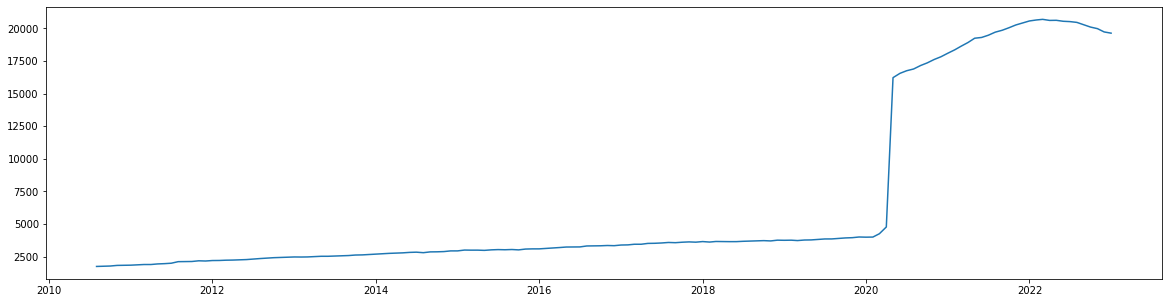

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends


In [55]:
process_fred_series(series_name="M1SL",
                    k_periods=150,
                    function_to_apply= lambda values: values,
                    bar=False)

In [56]:
# create_datawrapper_chart("M1 Money Supply", type_="d3-lines")

### Chart ID: 1HtAw

In [57]:
set_datawrapper_chart_properties(chart_id="1HtAw", 
                                  title="M1 Money Supply", 
                                  chart_type="d3-lines", 
                                  external_data="https://storage.googleapis.com/ufm-market-trends/united-states/fred/M1SL.csv",
                                  intro="Billions of Dollars, Seasonally Adjusted.", 
                                  byline="UFM Market Trends", 
                                  source_name="St. Louis Fed",
                                  source_url="https://fred.stlouisfed.org/series/M1SL",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=250)

Response: 200


{'publicId': '1HtAw',
 'language': 'en-US',
 'theme': 'datawrapper-data',
 'id': '1HtAw',
 'type': 'd3-lines',
 'title': 'M1 Money Supply',
 'lastEditStep': 3,
 'publishedAt': '2023-02-26T18:56:11.000Z',
 'publicUrl': 'https://datawrapper.dwcdn.net/1HtAw/4/',
 'publicVersion': 4,
 'deleted': False,
 'deletedAt': None,
 'forkable': False,
 'isFork': False,
 'metadata': {'data': {'changes': [],
   'transpose': False,
   'vertical-header': True,
   'horizontal-header': True,
   'column-format': {'values': {'number-divisor': 0}},
   'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/M1SL.csv',
   'upload-method': 'external-data',
   'use-datawrapper-cdn': True},
  'describe': {'source-name': 'St. Louis Fed',
   'source-url': 'https://fred.stlouisfed.org/series/M1SL',
   'intro': 'Billions of Dollars, Seasonally Adjusted.',
   'byline': 'UFM Market Trends',
   'aria-description': '',
   'number-format': '-',
   'number-divisor': 0,
   'number-append': '',


In [58]:
publish_datawrapper_chart(chart_id="1HtAw")

{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/1HtAw/


{'data': {'publicId': '1HtAw',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': '1HtAw',
  'type': 'd3-lines',
  'title': 'M1 Money Supply',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:34:42.222Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/1HtAw/5/',
  'publicVersion': 5,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/M1SL.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'St. Louis Fed',
    'source-url': 'https://fred.stlouisfed.org/series/M1SL',
    'intro': 'Billions of Dollars, Seasonally Adjusted.',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'number-format': '-',
    'number-

## Monetary base

https://fred.stlouisfed.org/series/BOGMBASE

https://fred.stlouisfed.org/categories/124

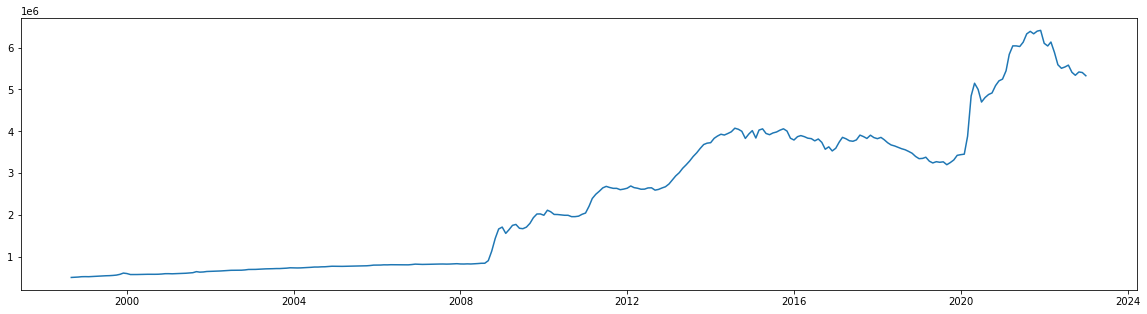

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends


In [59]:
process_fred_series(series_name="BOGMBASE",
                    k_periods=293,
                    function_to_apply= lambda values: values,
                    bar=False)

In [60]:
# create_datawrapper_chart("Monetary Base", type_="d3-lines")

### Chart ID: y4idO

In [61]:
set_datawrapper_chart_properties(chart_id="y4idO", 
                                  title="Monetary Base", 
                                  chart_type="d3-lines", 
                                  external_data="https://storage.googleapis.com/ufm-market-trends/united-states/fred/BOGMBASE.csv",
                                  intro="Millions of Dollars, Not Seasonally Adjusted", 
                                  byline="UFM Market Trends", 
                                  source_name="St. Louis Fed",
                                  source_url="https://fred.stlouisfed.org/series/BOGMBASE",
                                  y_grid_format="",
                                  number_divisor=0)

Response: 200


{'publicId': 'y4idO',
 'language': 'en-US',
 'theme': 'datawrapper-data',
 'id': 'y4idO',
 'type': 'd3-lines',
 'title': 'Monetary Base',
 'lastEditStep': 3,
 'publishedAt': '2023-02-26T18:56:15.000Z',
 'publicUrl': 'https://datawrapper.dwcdn.net/y4idO/3/',
 'publicVersion': 3,
 'deleted': False,
 'deletedAt': None,
 'forkable': False,
 'isFork': False,
 'metadata': {'data': {'changes': [],
   'transpose': False,
   'vertical-header': True,
   'horizontal-header': True,
   'column-format': {'values': {'number-divisor': 0}},
   'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/BOGMBASE.csv',
   'upload-method': 'external-data',
   'use-datawrapper-cdn': True},
  'describe': {'source-name': 'St. Louis Fed',
   'source-url': 'https://fred.stlouisfed.org/series/BOGMBASE',
   'intro': 'Millions of Dollars, Not Seasonally Adjusted',
   'byline': 'UFM Market Trends',
   'aria-description': '',
   'number-format': '-',
   'number-divisor': 0,
   'number-appe

In [62]:
publish_datawrapper_chart(chart_id="y4idO")

{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/y4idO/


{'data': {'publicId': 'y4idO',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'y4idO',
  'type': 'd3-lines',
  'title': 'Monetary Base',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:34:46.426Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/y4idO/4/',
  'publicVersion': 4,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/BOGMBASE.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'St. Louis Fed',
    'source-url': 'https://fred.stlouisfed.org/series/BOGMBASE',
    'intro': 'Millions of Dollars, Not Seasonally Adjusted',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'number-format': '-',
   

## Benchmark rates

3 month libor https://fred.stlouisfed.org/series/LIOR3M

in the uk https://fred.stlouisfed.org/series/LIOR3MUKM

overnight repo rate https://fred.stlouisfed.org/series/RRPONTSYAWARD

FED FUND RATE https://fred.stlouisfed.org/series/FEDFUNDS

interest on reserves https://fred.stlouisfed.org/series/IORB


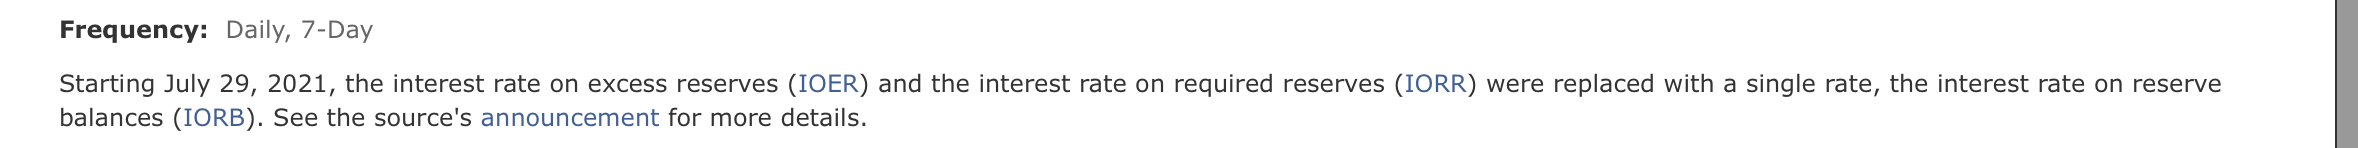

https://fred.stlouisfed.org/series/IOER

https://fred.stlouisfed.org/series/IORR

ON LIBOR: 

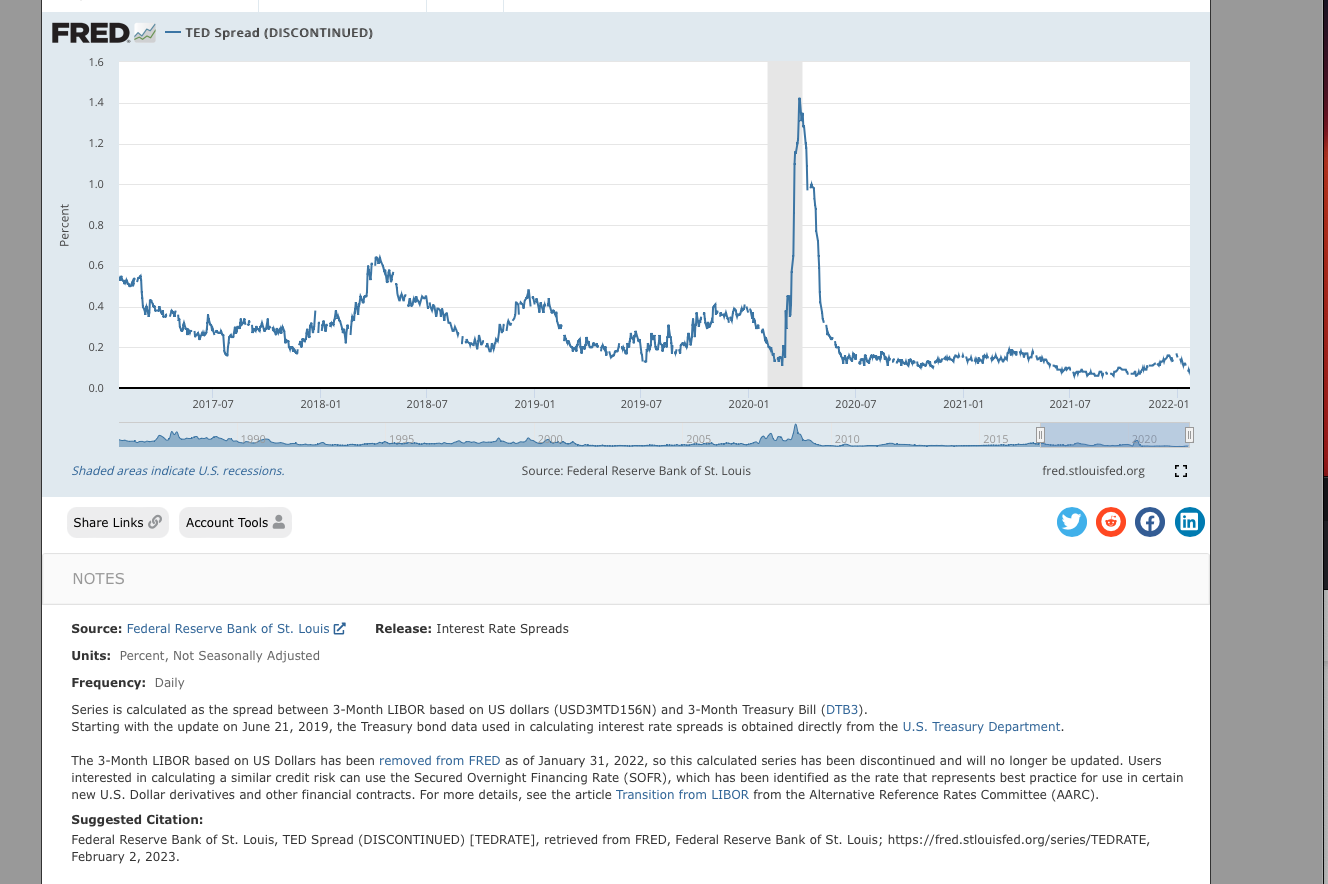

https://news.research.stlouisfed.org/2022/01/ice-benchmark-administration-ltd-iba-data-to-be-removed-from-fred/

### 3-month Libor

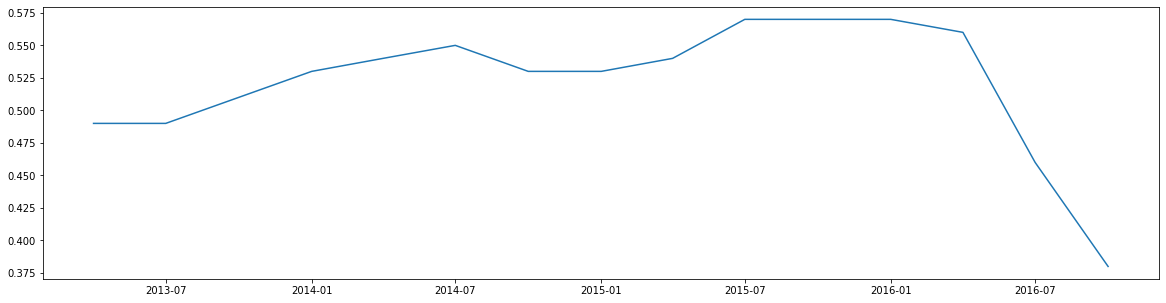

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends


In [63]:
process_fred_series(series_name="LIOR3M",
                    k_periods=15,
                    function_to_apply= lambda values: values,
                    bar=False)

In [64]:
# create_datawrapper_chart("3-Month LIBOR", type_="d3-lines")

#### Chart ID: xljW4

In [65]:
set_datawrapper_chart_properties(chart_id="xljW4", 
                                  title="3-Month Libor", 
                                  chart_type="d3-lines", 
                                  external_data="https://storage.googleapis.com/ufm-market-trends/united-states/fred/LIOR3M.csv",
                                  intro="Percent, Not Seasonally Adjusted.", 
                                  byline="UFM Market Trends", 
                                  source_name="St. Louis Fed",
                                  source_url="https://fred.stlouisfed.org/series/LIOR3M",
                                  y_grid_format="0.0%",
                                  number_divisor=0, chart_height=300)

Response: 200


{'publicId': 'xljW4',
 'language': 'en-US',
 'theme': 'datawrapper-data',
 'id': 'xljW4',
 'type': 'd3-lines',
 'title': '3-Month Libor',
 'lastEditStep': 3,
 'publishedAt': '2023-02-26T18:56:18.000Z',
 'publicUrl': 'https://datawrapper.dwcdn.net/xljW4/5/',
 'publicVersion': 5,
 'deleted': False,
 'deletedAt': None,
 'forkable': False,
 'isFork': False,
 'metadata': {'data': {'changes': [],
   'transpose': False,
   'vertical-header': True,
   'horizontal-header': True,
   'column-format': {'values': {'number-divisor': 0}},
   'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/LIOR3M.csv',
   'upload-method': 'external-data',
   'use-datawrapper-cdn': True},
  'describe': {'source-name': 'St. Louis Fed',
   'source-url': 'https://fred.stlouisfed.org/series/LIOR3M',
   'intro': 'Percent, Not Seasonally Adjusted.',
   'byline': 'UFM Market Trends',
   'aria-description': '',
   'number-format': '-',
   'number-divisor': 0,
   'number-append': '',
   'nu

In [66]:
publish_datawrapper_chart(chart_id="xljW4")

{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/xljW4/


{'data': {'publicId': 'xljW4',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'xljW4',
  'type': 'd3-lines',
  'title': '3-Month Libor',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:34:49.676Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/xljW4/6/',
  'publicVersion': 6,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/LIOR3M.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'St. Louis Fed',
    'source-url': 'https://fred.stlouisfed.org/series/LIOR3M',
    'intro': 'Percent, Not Seasonally Adjusted.',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'number-format': '-',
    'number-diviso

### Overnight Repo Rate

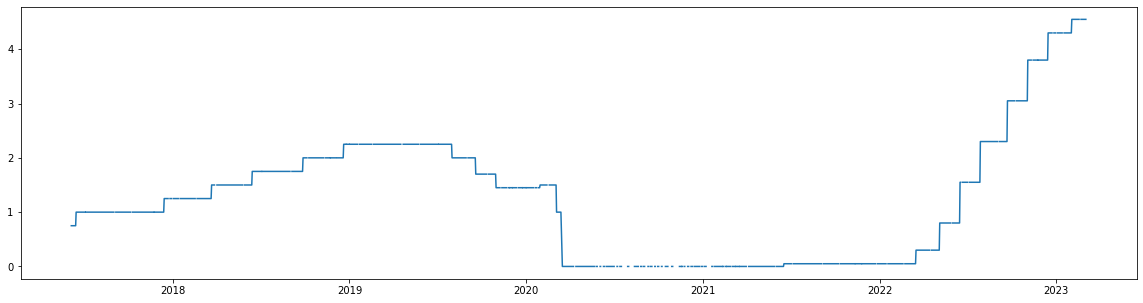

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends


In [67]:
process_fred_series(series_name="RRPONTSYAWARD",
                    k_periods=1500,
                    function_to_apply= lambda values: values,
                    bar=False)

In [68]:
# create_datawrapper_chart("Overnight Repo Rate", type_="d3-lines")

#### Chart ID: cbBtB

In [69]:
set_datawrapper_chart_properties(chart_id="cbBtB", 
                                  title="Overnight Repo Rate", 
                                  chart_type="d3-lines", 
                                  external_data="https://storage.googleapis.com/ufm-market-trends/united-states/fred/RRPONTSYAWARD.csv",
                                  intro="Percent, Not Seasonally Adjusted.", 
                                  byline="UFM Market Trends", 
                                  source_name="St. Louis Fed",
                                  source_url="https://fred.stlouisfed.org/series/RRPONTSYAWARD",
                                  y_grid_format="0.0%",
                                  number_divisor=0, chart_height=300)

Response: 200


{'publicId': 'cbBtB',
 'language': 'en-US',
 'theme': 'datawrapper-data',
 'id': 'cbBtB',
 'type': 'd3-lines',
 'title': 'Overnight Repo Rate',
 'lastEditStep': 3,
 'publishedAt': '2023-02-26T18:56:22.000Z',
 'publicUrl': 'https://datawrapper.dwcdn.net/cbBtB/4/',
 'publicVersion': 4,
 'deleted': False,
 'deletedAt': None,
 'forkable': False,
 'isFork': False,
 'metadata': {'data': {'changes': [],
   'transpose': False,
   'vertical-header': True,
   'horizontal-header': True,
   'column-format': {'values': {'number-divisor': 0}},
   'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/RRPONTSYAWARD.csv',
   'upload-method': 'external-data',
   'use-datawrapper-cdn': True},
  'describe': {'source-name': 'St. Louis Fed',
   'source-url': 'https://fred.stlouisfed.org/series/RRPONTSYAWARD',
   'intro': 'Percent, Not Seasonally Adjusted.',
   'byline': 'UFM Market Trends',
   'aria-description': '',
   'number-format': '-',
   'number-divisor': 0,
   'number

In [70]:
publish_datawrapper_chart(chart_id="cbBtB")

{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/cbBtB/


{'data': {'publicId': 'cbBtB',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'cbBtB',
  'type': 'd3-lines',
  'title': 'Overnight Repo Rate',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:34:54.507Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/cbBtB/5/',
  'publicVersion': 5,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/RRPONTSYAWARD.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'St. Louis Fed',
    'source-url': 'https://fred.stlouisfed.org/series/RRPONTSYAWARD',
    'intro': 'Percent, Not Seasonally Adjusted.',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'number-format': '-'

### Fed Fund Rate

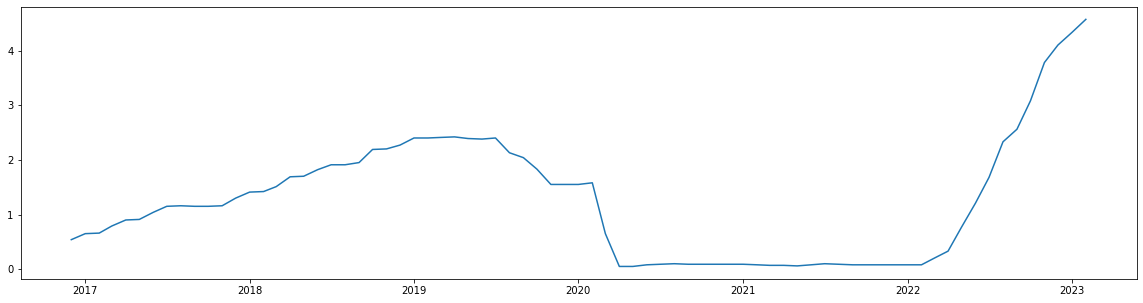

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends


In [71]:
process_fred_series(series_name="FEDFUNDS",
                    k_periods=75,
                    function_to_apply= lambda values: values,
                    bar=False)

In [72]:
# create_datawrapper_chart("(Effective) Fed Funds RATE", type_="d3-lines")

#### Chart ID: sgeZE

In [73]:
set_datawrapper_chart_properties(chart_id="sgeZE", 
                                  title="(Effective) Fed Funds RATE", 
                                  chart_type="d3-lines", 
                                  external_data="https://storage.googleapis.com/ufm-market-trends/united-states/fred/FEDFUNDS.csv",
                                  intro="Percent, Not Seasonally Adjusted.", 
                                  byline="UFM Market Trends", 
                                  source_name="St. Louis Fed",
                                  source_url="https://fred.stlouisfed.org/series/FEDFUNDS",
                                  y_grid_format="0.0%",
                                  number_divisor=0, chart_height=300)

Response: 200


{'publicId': 'sgeZE',
 'language': 'en-US',
 'theme': 'datawrapper-data',
 'id': 'sgeZE',
 'type': 'd3-lines',
 'title': '(Effective) Fed Funds RATE',
 'lastEditStep': 3,
 'publishedAt': '2023-02-26T18:56:25.000Z',
 'publicUrl': 'https://datawrapper.dwcdn.net/sgeZE/3/',
 'publicVersion': 3,
 'deleted': False,
 'deletedAt': None,
 'forkable': False,
 'isFork': False,
 'metadata': {'data': {'changes': [],
   'transpose': False,
   'vertical-header': True,
   'horizontal-header': True,
   'column-format': {'values': {'number-divisor': 0}},
   'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/FEDFUNDS.csv',
   'upload-method': 'external-data',
   'use-datawrapper-cdn': True},
  'describe': {'source-name': 'St. Louis Fed',
   'source-url': 'https://fred.stlouisfed.org/series/FEDFUNDS',
   'intro': 'Percent, Not Seasonally Adjusted.',
   'byline': 'UFM Market Trends',
   'aria-description': '',
   'number-format': '-',
   'number-divisor': 0,
   'number-ap

In [74]:
publish_datawrapper_chart(chart_id="sgeZE")

{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/sgeZE/


{'data': {'publicId': 'sgeZE',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'sgeZE',
  'type': 'd3-lines',
  'title': '(Effective) Fed Funds RATE',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:34:59.814Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/sgeZE/4/',
  'publicVersion': 4,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/FEDFUNDS.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'St. Louis Fed',
    'source-url': 'https://fred.stlouisfed.org/series/FEDFUNDS',
    'intro': 'Percent, Not Seasonally Adjusted.',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'number-format': '-',
 

### Interest on Reserve Balances

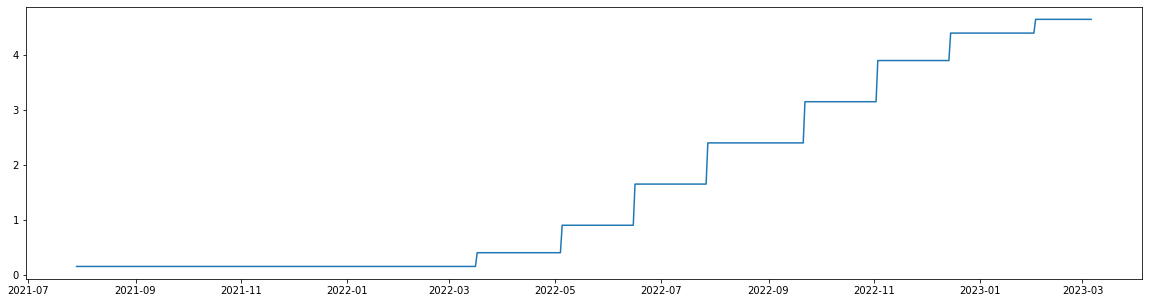

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends


In [75]:
process_fred_series(series_name="IORB",
                    k_periods=3000,
                    function_to_apply= lambda values: values,
                    bar=False)

In [76]:
# create_datawrapper_chart("Interest on Reserve Balances", type_="d3-lines")

#### Chart ID: 07re8

In [77]:
set_datawrapper_chart_properties(chart_id="07re8", 
                                  title="Interest on Reserve Balances", 
                                  chart_type="d3-lines", 
                                  external_data="https://storage.googleapis.com/ufm-market-trends/united-states/fred/IORB.csv",
                                  intro="Percent, Not Seasonally Adjusted.", 
                                  byline="UFM Market Trends", 
                                  source_name="St. Louis Fed",
                                  source_url="https://fred.stlouisfed.org/series/IORB",
                                  y_grid_format="0.0%",
                                  number_divisor=0, chart_height=300)

Response: 200


{'publicId': '07re8',
 'language': 'en-US',
 'theme': 'datawrapper-data',
 'id': '07re8',
 'type': 'd3-lines',
 'title': 'Interest on Reserve Balances',
 'lastEditStep': 3,
 'publishedAt': '2023-02-26T18:56:29.000Z',
 'publicUrl': 'https://datawrapper.dwcdn.net/07re8/2/',
 'publicVersion': 2,
 'deleted': False,
 'deletedAt': None,
 'forkable': False,
 'isFork': False,
 'metadata': {'data': {'changes': [],
   'transpose': False,
   'vertical-header': True,
   'horizontal-header': True,
   'column-format': {'values': {'number-divisor': 0}},
   'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/IORB.csv',
   'upload-method': 'external-data',
   'use-datawrapper-cdn': True},
  'describe': {'source-name': 'St. Louis Fed',
   'source-url': 'https://fred.stlouisfed.org/series/IORB',
   'intro': 'Percent, Not Seasonally Adjusted.',
   'byline': 'UFM Market Trends',
   'aria-description': '',
   'number-format': '-',
   'number-divisor': 0,
   'number-append':

In [78]:
publish_datawrapper_chart(chart_id="07re8")

{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/07re8/


{'data': {'publicId': '07re8',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': '07re8',
  'type': 'd3-lines',
  'title': 'Interest on Reserve Balances',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:35:04.144Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/07re8/3/',
  'publicVersion': 3,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/IORB.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'St. Louis Fed',
    'source-url': 'https://fred.stlouisfed.org/series/IORB',
    'intro': 'Percent, Not Seasonally Adjusted.',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'number-format': '-',
    'nu

## Stock market indexes 

https://fred.stlouisfed.org/categories/32255

### SP-500

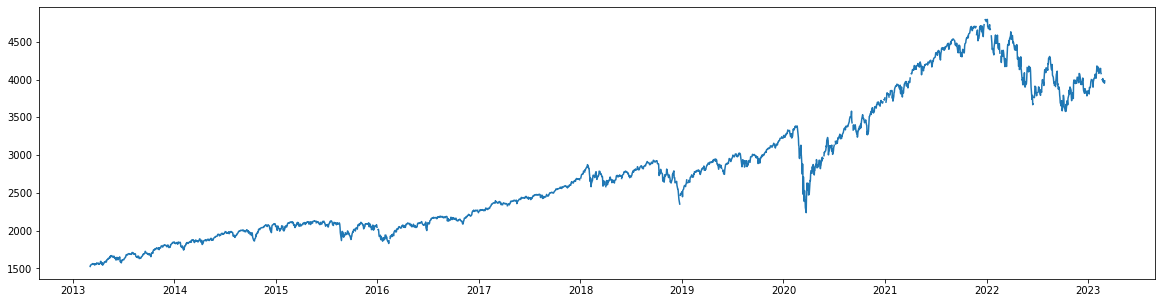

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends


In [79]:
process_fred_series(series_name="SP500",
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

In [80]:
# create_datawrapper_chart("SP-500", type_="d3-lines")

#### Chart ID: L1fop

In [81]:
set_datawrapper_chart_properties(chart_id="L1fop", 
                                  title="SP-500", 
                                  chart_type="d3-lines", 
                                  external_data="https://storage.googleapis.com/ufm-market-trends/united-states/fred/SP500.csv",
                                  intro="Index, Not Seasonally Adjusted.", 
                                  byline="UFM Market Trends", 
                                  source_name="S&P Dow Jones Indices LLC",
                                  source_url="https://fred.stlouisfed.org/series/SP500",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

Response: 200


{'publicId': 'L1fop',
 'language': 'en-US',
 'theme': 'datawrapper-data',
 'id': 'L1fop',
 'type': 'd3-lines',
 'title': 'SP-500',
 'lastEditStep': 3,
 'publishedAt': '2023-02-26T18:56:33.000Z',
 'publicUrl': 'https://datawrapper.dwcdn.net/L1fop/3/',
 'publicVersion': 3,
 'deleted': False,
 'deletedAt': None,
 'forkable': False,
 'isFork': False,
 'metadata': {'data': {'changes': [],
   'transpose': False,
   'vertical-header': True,
   'horizontal-header': True,
   'column-format': {'values': {'number-divisor': 0}},
   'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/SP500.csv',
   'upload-method': 'external-data',
   'use-datawrapper-cdn': True},
  'describe': {'source-name': 'S&P Dow Jones Indices LLC',
   'source-url': 'https://fred.stlouisfed.org/series/SP500',
   'intro': 'Index, Not Seasonally Adjusted.',
   'byline': 'UFM Market Trends',
   'aria-description': '',
   'number-format': '-',
   'number-divisor': 0,
   'number-append': '',
   'n

In [82]:
publish_datawrapper_chart(chart_id="L1fop")

{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/L1fop/


{'data': {'publicId': 'L1fop',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'L1fop',
  'type': 'd3-lines',
  'title': 'SP-500',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:35:09.419Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/L1fop/4/',
  'publicVersion': 4,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/SP500.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'S&P Dow Jones Indices LLC',
    'source-url': 'https://fred.stlouisfed.org/series/SP500',
    'intro': 'Index, Not Seasonally Adjusted.',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'number-format': '-',
    'number-divis

### NASDAQ Composite Index

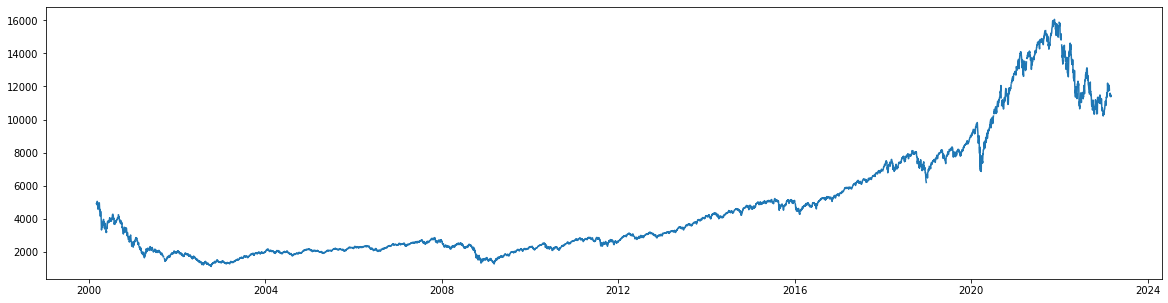

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: XDfun 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/XDfun/


{'data': {'publicId': 'XDfun',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'XDfun',
  'type': 'd3-lines',
  'title': 'NASDAQ Composite Index',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:35:16.404Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/XDfun/7/',
  'publicVersion': 7,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/NASDAQCOM.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'NASDAQ OMX Group ',
    'source-url': 'https://fred.stlouisfed.org/series/NASDAQCOM',
    'intro': 'Index Feb 5, 1971=100, Not Seasonally Adjusted',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'number-

In [83]:
series = "NASDAQCOM"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# response_object = create_datawrapper_chart("NASDAQ Composite Index", type_="d3-lines")
chart_id = "XDfun"#response_object["publicId"]
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title="NASDAQ Composite Index", 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Index Feb 5, 1971=100, Not Seasonally Adjusted", 
                                  byline="UFM Market Trends", 
                                  source_name="NASDAQ OMX Group ",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

###  Dow Jones Industrial Average (DJIA)	

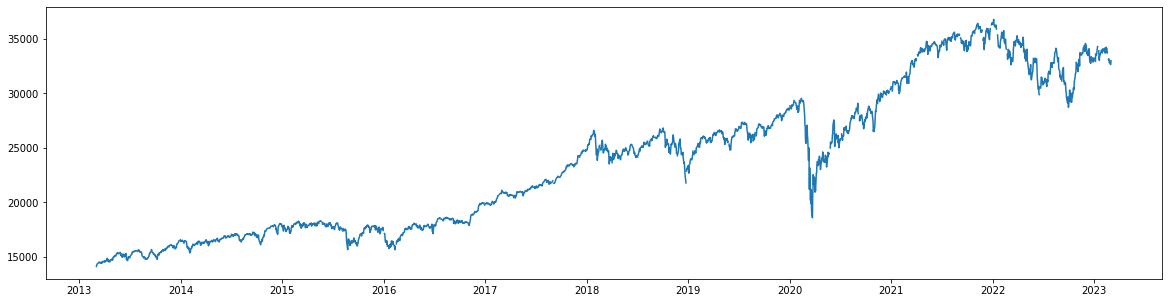

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: VaC8T 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/VaC8T/


{'data': {'publicId': 'VaC8T',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'VaC8T',
  'type': 'd3-lines',
  'title': 'Dow Jones Industrial Average',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:35:21.162Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/VaC8T/4/',
  'publicVersion': 4,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/DJIA.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'S&P Dow Jones Indices LLC ',
    'source-url': 'https://fred.stlouisfed.org/series/DJIA',
    'intro': 'Index, Not Seasonally Adjusted',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'number-format': '-

In [84]:
series = "DJIA"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# response_object = create_datawrapper_chart("NASDAQ Composite Index", type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "VaC8T"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title="Dow Jones Industrial Average", 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Index, Not Seasonally Adjusted", 
                                  byline="UFM Market Trends", 
                                  source_name="S&P Dow Jones Indices LLC ",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

## Consumer price index 

https://fred.stlouisfed.org/categories/9

###  Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)	

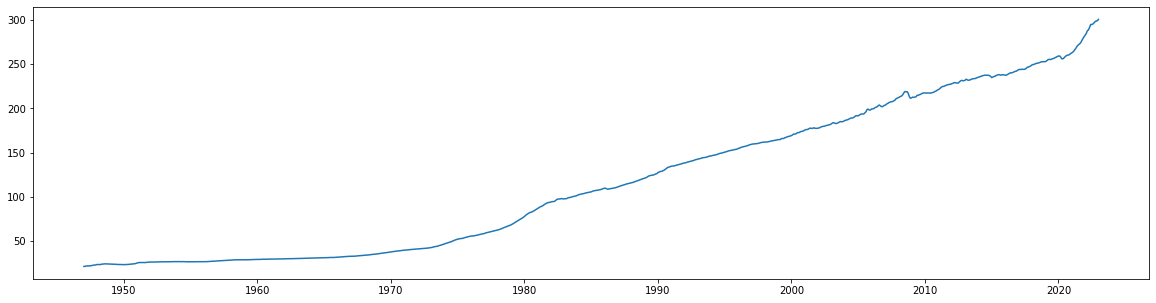

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: 0HVul 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/0HVul/


{'data': {'publicId': '0HVul',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': '0HVul',
  'type': 'd3-lines',
  'title': 'Consumer Price Index for All Urban Consumers: All Items in U.S. City Average',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:35:24.789Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/0HVul/4/',
  'publicVersion': 4,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/CPIAUCSL.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'U.S. Bureau of Labor Statistics',
    'source-url': 'https://fred.stlouisfed.org/series/CPIAUCSL',
    'intro': 'Index 1982-1984=100, Seasonally Adjusted',
    'byline': '

In [85]:
series = "CPIAUCSL"
chart_title = "Consumer Price Index for All Urban Consumers: All Items in U.S. City Average"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "0HVul"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Index 1982-1984=100, Seasonally Adjusted", 
                                  byline="UFM Market Trends", 
                                  source_name="U.S. Bureau of Labor Statistics",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

###  Sticky Price Consumer Price Index less Food and Energy (CORESTICKM159SFRBATL)	

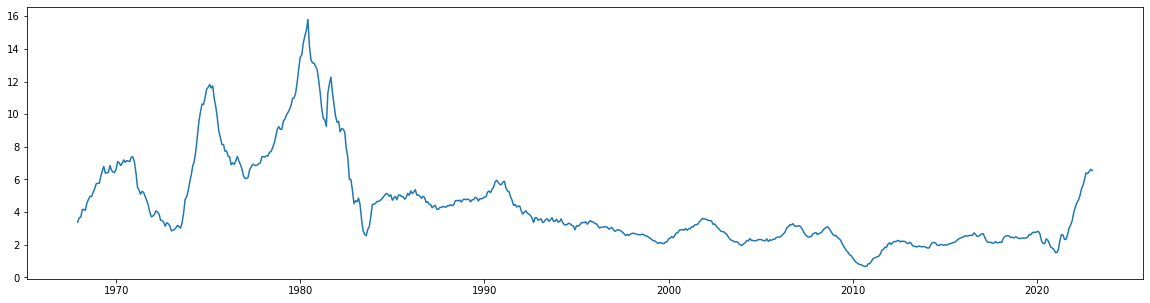

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: nGXhb 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/nGXhb/


{'data': {'publicId': 'nGXhb',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'nGXhb',
  'type': 'd3-lines',
  'title': 'Sticky Price Consumer Price Index less Food and Energy',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:35:28.077Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/nGXhb/4/',
  'publicVersion': 4,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/CORESTICKM159SFRBATL.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'Federal Reserve Bank of Atlanta',
    'source-url': 'https://fred.stlouisfed.org/series/CORESTICKM159SFRBATL',
    'intro': 'Percent Change from Year Ago, Seasonally Adjusted',
    

In [86]:
series = "CORESTICKM159SFRBATL"
chart_title = "Sticky Price Consumer Price Index less Food and Energy"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "nGXhb"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Percent Change from Year Ago, Seasonally Adjusted", 
                                  byline="UFM Market Trends", 
                                  source_name="Federal Reserve Bank of Atlanta",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="0.0%",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

####  Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index) (PCEPILFE)	

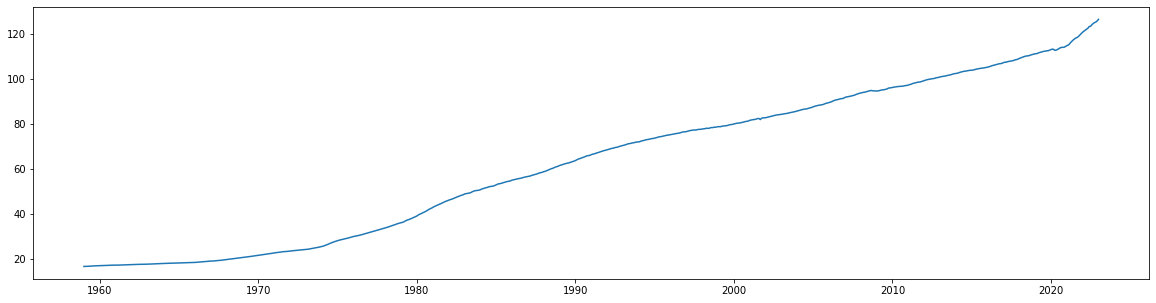

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: CuzEL 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/CuzEL/


{'data': {'publicId': 'CuzEL',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'CuzEL',
  'type': 'd3-lines',
  'title': ' Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index)',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:35:31.785Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/CuzEL/4/',
  'publicVersion': 4,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/PCEPILFE.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': ' U.S. Bureau of Economic Analysis ',
    'source-url': 'https://fred.stlouisfed.org/series/PCEPILFE',
    'intro': 'Index 2012=100, Seasonally Adjusted',
    'byl

In [87]:
series = "PCEPILFE"
chart_title = " Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index)"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "CuzEL"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Index 2012=100, Seasonally Adjusted", 
                                  byline="UFM Market Trends", 
                                  source_name=" U.S. Bureau of Economic Analysis ",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

## Producer Price Index by Commodity: Final Demand

https://fred.stlouisfed.org/series/PPIFIS

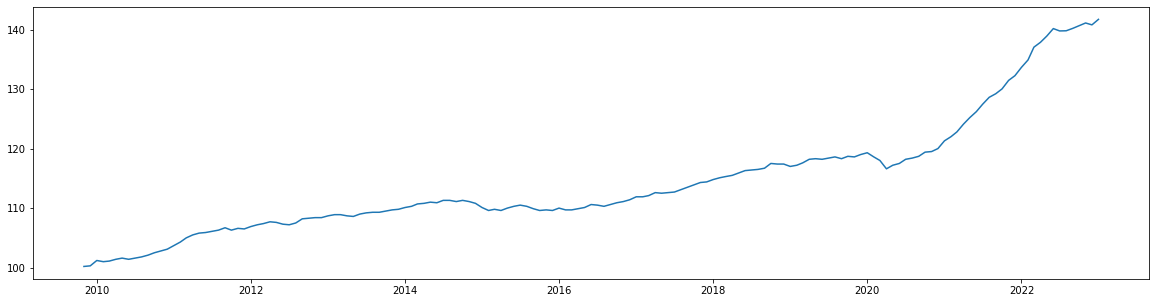

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: mOmfl 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/mOmfl/


{'data': {'publicId': 'mOmfl',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'mOmfl',
  'type': 'd3-lines',
  'title': 'Producer Price Index by Commodity: Final Demand',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:35:35.230Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/mOmfl/4/',
  'publicVersion': 4,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/PPIFIS.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'U.S. Bureau of Labor Statistics',
    'source-url': 'https://fred.stlouisfed.org/series/PPIFIS',
    'intro': 'Index Nov 2009=100, Seasonally Adjusted',
    'byline': 'UFM Market Trends',
    'aria-desc

In [88]:
series = "PPIFIS"
chart_title = "Producer Price Index by Commodity: Final Demand"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "mOmfl"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Index Nov 2009=100, Seasonally Adjusted", 
                                  byline="UFM Market Trends", 
                                  source_name="U.S. Bureau of Labor Statistics",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

## Inflation expectations

https://fred.stlouisfed.org/release?rid=500

### 10-Year Expected Inflation (EXPINF10YR)	

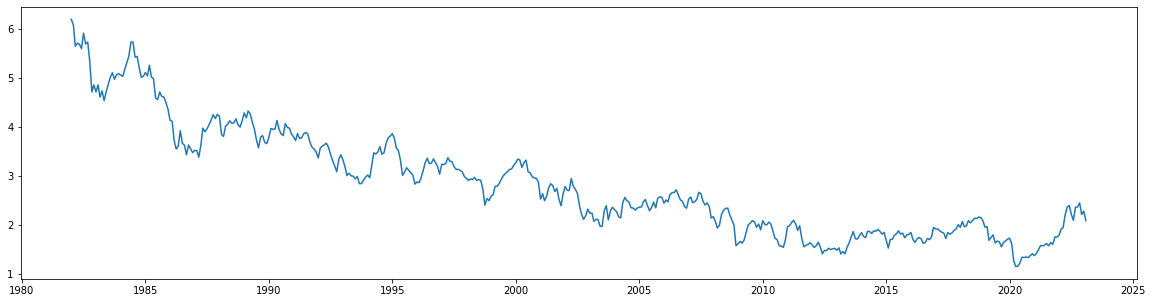

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: rRR1b 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/rRR1b/


{'data': {'publicId': 'rRR1b',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'rRR1b',
  'type': 'd3-lines',
  'title': '10-Year Expected Inflation',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:35:38.515Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/rRR1b/4/',
  'publicVersion': 4,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/EXPINF10YR.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'Federal Reserve Bank of Cleveland',
    'source-url': 'https://fred.stlouisfed.org/series/EXPINF10YR',
    'intro': 'Percent, Not Seasonally Adjusted',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    

In [89]:
series = "EXPINF10YR"
chart_title = "10-Year Expected Inflation"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "rRR1b"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Percent, Not Seasonally Adjusted", 
                                  byline="UFM Market Trends", 
                                  source_name="Federal Reserve Bank of Cleveland",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

# INTEREST RATES AND BANKING

## TIPS Yield Curve

https://fred.stlouisfed.org/tags/series?t=tips

https://fred.stlouisfed.org/tags/series?t=10-year%3Btips

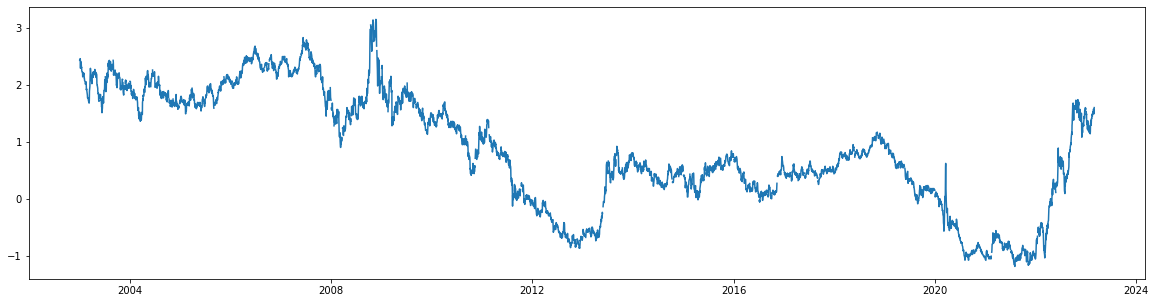

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: DV6B9 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/DV6B9/


{'data': {'publicId': 'DV6B9',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'DV6B9',
  'type': 'd3-lines',
  'title': '10-Year TIPS Rate',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:48:41.772Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/DV6B9/2/',
  'publicVersion': 2,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/DFII10.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'Board of Governors of the Federal Reserve System (US)',
    'source-url': 'https://fred.stlouisfed.org/series/DFII10',
    'intro': 'Percent, Not Seasonally Adjusted',
    'byline': 'UFM Market Trends',
    'aria-description': '',
 

In [91]:
series = "DFII10"
chart_title = "10-Year TIPS Rate"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "DV6B9"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Percent, Not Seasonally Adjusted", 
                                  byline="UFM Market Trends", 
                                  source_name="Board of Governors of the Federal Reserve System (US)",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

## Corporate yields

https://fred.stlouisfed.org/categories/32348

https://fred.stlouisfed.org/release?rid=402

https://fred.stlouisfed.org/tags/series?t=bonds%3Bcorporate%3Byield

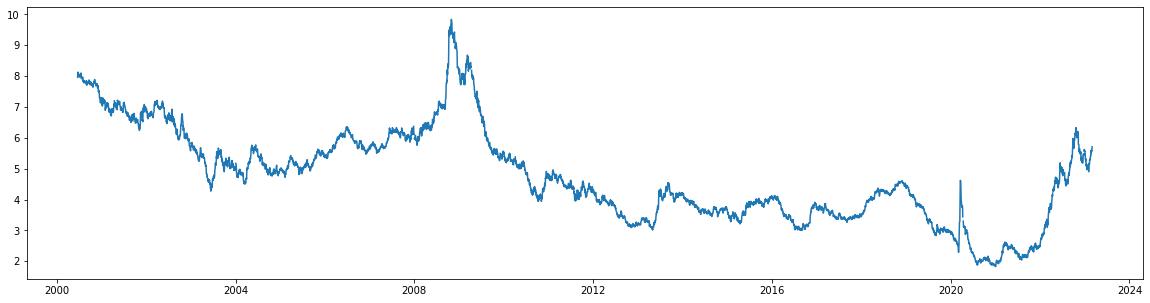

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: l6jis 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/l6jis/


{'data': {'publicId': 'l6jis',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'l6jis',
  'type': 'd3-lines',
  'title': '7-10 Year US Corporate Index Effective Yield',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T22:53:14.712Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/l6jis/2/',
  'publicVersion': 2,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/BAMLC4A0C710YEY.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'ICE Benchmark Administration (IBA), ICE BofAML Indices',
    'source-url': 'https://fred.stlouisfed.org/series/BAMLC4A0C710YEY',
    'intro': 'Percent, Not Seasonally Adjusted',
    'byline': 'UFM

In [93]:
series = "BAMLC4A0C710YEY"
chart_title = "7-10 Year US Corporate Index Effective Yield"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "l6jis"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Percent, Not Seasonally Adjusted", 
                                  byline="UFM Market Trends", 
                                  source_name="ICE Benchmark Administration (IBA), ICE BofAML Indices",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

## TED spread 

https://fred.stlouisfed.org/series/TEDRATE

In [89]:
# Discontinued

## Secured Overnight Financing Rate



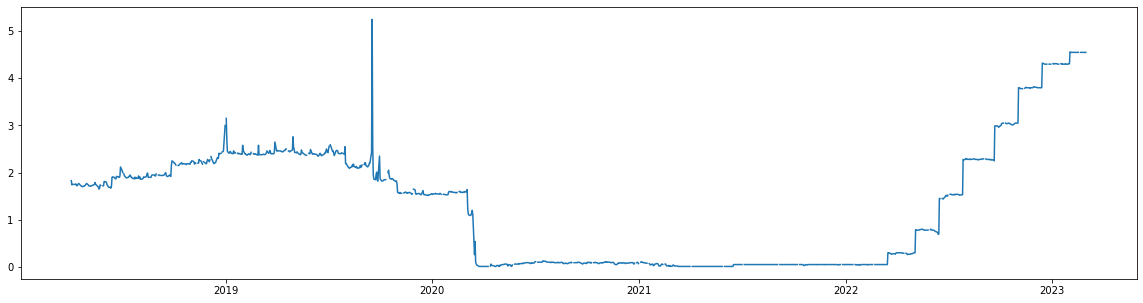

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: grayO 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/grayO/


{'data': {'publicId': 'grayO',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'grayO',
  'type': 'd3-lines',
  'title': 'Secured Overnight Financing Rate',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T23:01:28.499Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/grayO/3/',
  'publicVersion': 3,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/SOFR.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': ' Federal Reserve Bank of New York',
    'source-url': 'https://fred.stlouisfed.org/series/SOFR',
    'intro': 'Percent, Not Seasonally Adjusted',
    'byline': 'UFM Market Trends',
    'aria-description': '',
    'numbe

In [96]:
series = "SOFR"
chart_title = "Secured Overnight Financing Rate"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "grayO"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Percent, Not Seasonally Adjusted", 
                                  byline="UFM Market Trends", 
                                  source_name=" Federal Reserve Bank of New York",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

## Household Debt


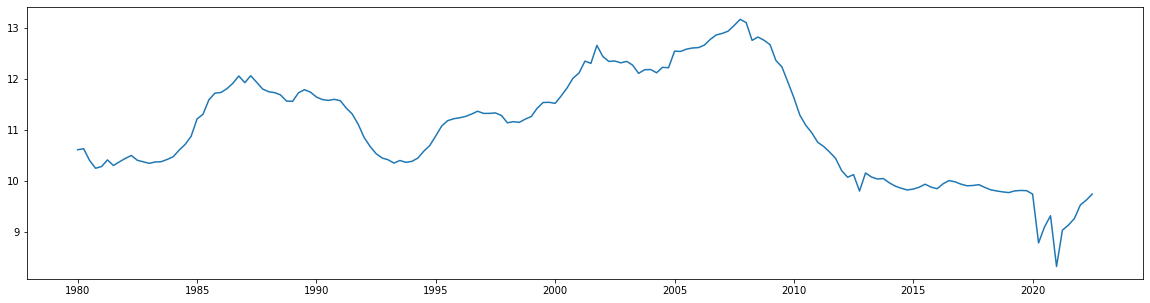

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: 3D17z 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/3D17z/


{'data': {'publicId': '3D17z',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': '3D17z',
  'type': 'd3-lines',
  'title': 'Household Debt',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T23:34:47.545Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/3D17z/2/',
  'publicVersion': 2,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/TDSP.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'Board of Governors of the Federal Reserve System (US), Release: Household Debt Service and Financial Obligations Ratios',
    'source-url': 'https://fred.stlouisfed.org/series/TDSP',
    'intro': 'Household Debt Service Payments as a Per

In [100]:
series = "TDSP"
chart_title = "Household Debt"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "3D17z"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Household Debt Service Payments as a Percent of Disposable Personal Income", 
                                  byline="UFM Market Trends", 
                                  source_name="Board of Governors of the Federal Reserve System (US), Release: Household Debt Service and Financial Obligations Ratios",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

## Corporate Liquidity


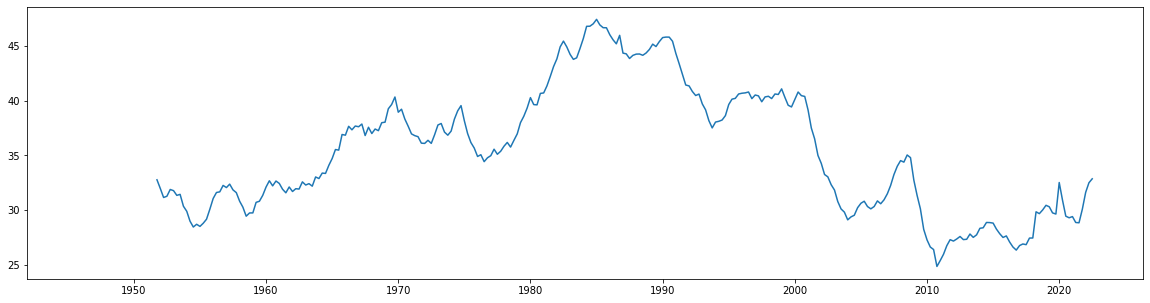

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: C2bBj 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/C2bBj/


{'data': {'publicId': 'C2bBj',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'C2bBj',
  'type': 'd3-lines',
  'title': 'Corporate Liquidity',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T23:35:33.921Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/C2bBj/3/',
  'publicVersion': 3,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/BOGZ1FL104140006Q.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'Board of Governors of the Federal Reserve System (US), Release: Z.1 Financial Accounts of the United States',
    'source-url': 'https://fred.stlouisfed.org/series/BOGZ1FL104140006Q',
    'intro': 'Short-term debt as % 

In [101]:
series = "BOGZ1FL104140006Q"
chart_title = "Corporate Liquidity"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "C2bBj"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Short-term debt as % of total debt", 
                                  byline="UFM Market Trends", 
                                  source_name="Board of Governors of the Federal Reserve System (US), Release: Z.1 Financial Accounts of the United States",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

## Commercial Loans

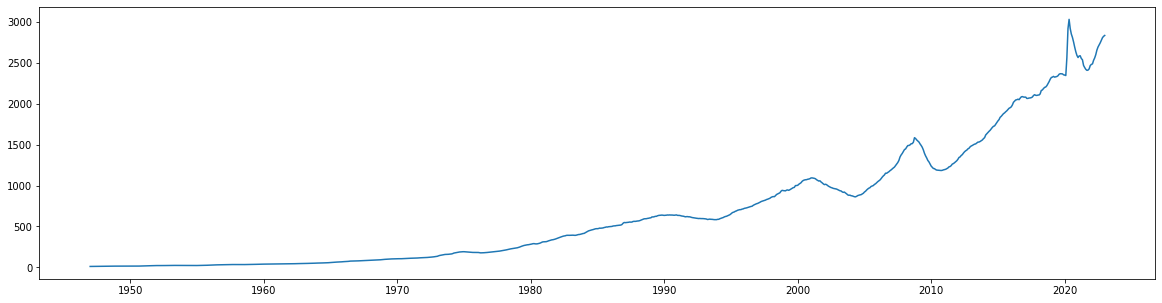

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: p5jWF 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/p5jWF/


{'data': {'publicId': 'p5jWF',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'p5jWF',
  'type': 'd3-lines',
  'title': 'Commercial and Industrial Loans, All Commercial Banks',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T23:39:25.085Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/p5jWF/2/',
  'publicVersion': 2,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/BUSLOANS.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'Source: Board of Governors of the Federal Reserve System (US), Release: H.8',
    'source-url': 'https://fred.stlouisfed.org/series/BUSLOANS',
    'intro': 'Billions of U.S. Dollars, Seasonally 

In [103]:
series = "BUSLOANS"
chart_title = "Commercial and Industrial Loans, All Commercial Banks"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "p5jWF"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Billions of U.S. Dollars, Seasonally Adjusted", 
                                  byline="UFM Market Trends", 
                                  source_name="Source: Board of Governors of the Federal Reserve System (US), Release: H.8",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

## Delinquency Rate

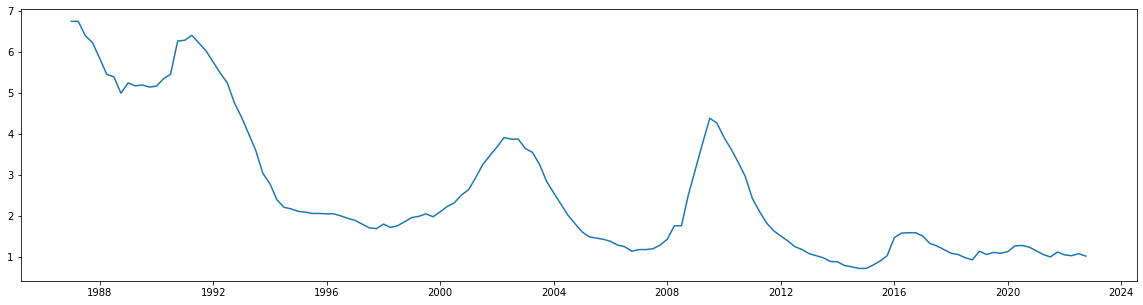

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: h1aBw 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/h1aBw/


{'data': {'publicId': 'h1aBw',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'h1aBw',
  'type': 'd3-lines',
  'title': 'Delinquency Rate on Business Loans, All Commercial Banks',
  'lastEditStep': 5,
  'publishedAt': '2023-03-03T23:49:31.759Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/h1aBw/3/',
  'publicVersion': 3,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/DRBLACBS.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'Board of Governors of the Federal Reserve System (US)',
    'source-url': 'https://fred.stlouisfed.org/series/DRBLACBS',
    'intro': 'Percent, Seasonally Adjusted',
    'byline': 'UFM Market

In [106]:
series = "DRBLACBS"
chart_title = "Delinquency Rate on Business Loans, All Commercial Banks"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "h1aBw"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Percent, Seasonally Adjusted", 
                                  byline="UFM Market Trends", 
                                  source_name="Board of Governors of the Federal Reserve System (US)",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

## Commercial Loans

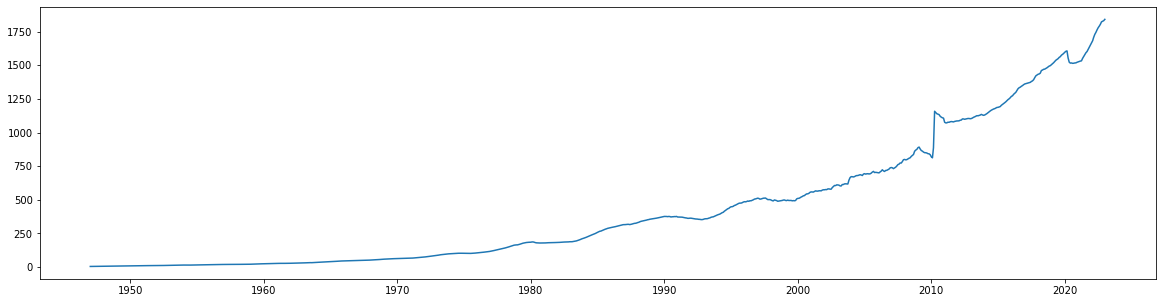

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: b84zr 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/b84zr/


{'data': {'publicId': 'b84zr',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'b84zr',
  'type': 'd3-lines',
  'title': 'Consumer Loans, All Commercial Banks',
  'lastEditStep': 5,
  'publishedAt': '2023-03-04T00:02:42.913Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/b84zr/2/',
  'publicVersion': 2,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/CONSUMER.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'Board of Governors of the Federal Reserve System (US)',
    'source-url': 'https://fred.stlouisfed.org/series/CONSUMER',
    'intro': 'Billions of U.S. Dollars, Seasonally Adjusted',
    'byline': 'UFM Market Tr

In [108]:
series = "CONSUMER"
chart_title = "Consumer Loans, All Commercial Banks"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "b84zr"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Billions of U.S. Dollars, Seasonally Adjusted", 
                                  byline="UFM Market Trends", 
                                  source_name="Board of Governors of the Federal Reserve System (US)",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

# FISCAL OUTLOOK

## Public debt

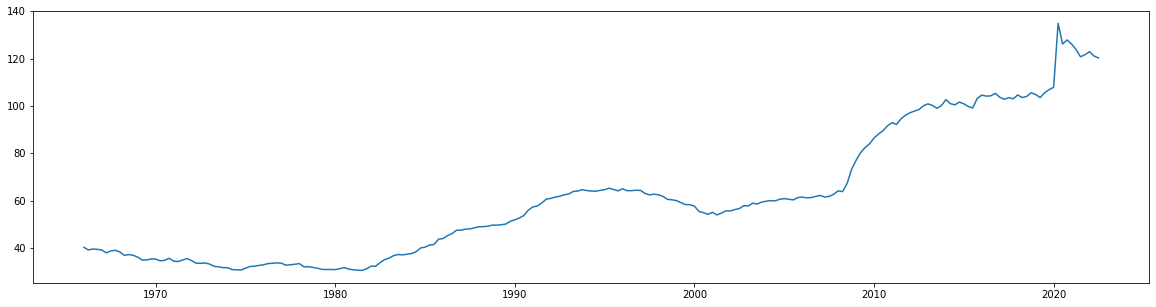

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: JKIii 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/JKIii/


{'data': {'publicId': 'JKIii',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'JKIii',
  'type': 'd3-lines',
  'title': 'Federal Debt: Total Public Debt as Percent of Gross Domestic Product',
  'lastEditStep': 5,
  'publishedAt': '2023-03-04T00:11:50.280Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/JKIii/2/',
  'publicVersion': 2,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/GFDEGDQ188S.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'St Louis Fed',
    'source-url': 'https://fred.stlouisfed.org/series/GFDEGDQ188S',
    'intro': 'Percent of GDP, Seasonally Adjusted',
    'byline': 'UFM Market Trends',
    'a

In [110]:
series = "GFDEGDQ188S"
chart_title = "Federal Debt: Total Public Debt as Percent of Gross Domestic Product"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "JKIii"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Percent of GDP, Seasonally Adjusted", 
                                  byline="UFM Market Trends", 
                                  source_name="St Louis Fed",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

## Current Tax Receipts

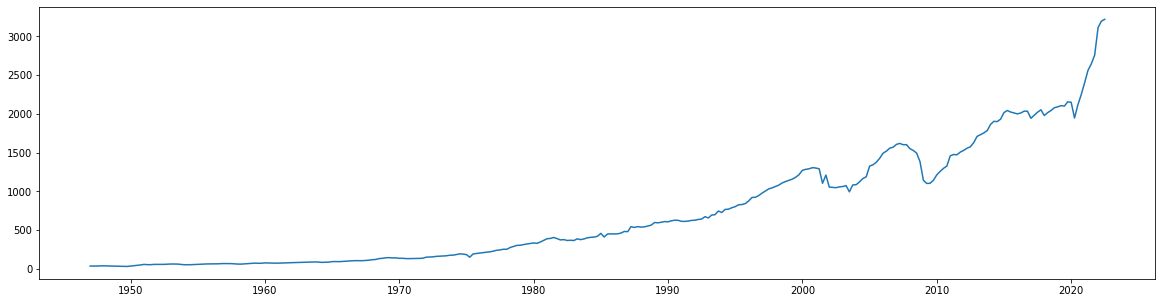

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: Me9uK 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/Me9uK/


{'data': {'publicId': 'Me9uK',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'Me9uK',
  'type': 'd3-lines',
  'title': 'Federal government current tax receipts',
  'lastEditStep': 5,
  'publishedAt': '2023-03-04T00:15:42.815Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/Me9uK/2/',
  'publicVersion': 2,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/W006RC1Q027SBEA.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'U.S. Bureau of Economic Analysis',
    'source-url': 'https://fred.stlouisfed.org/series/W006RC1Q027SBEA',
    'intro': 'Billions of Dollars, Seasonally Adjusted Annual Rate',
    'byline': 'UFM Market

In [112]:
series = "W006RC1Q027SBEA"
chart_title = "Federal government current tax receipts"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "Me9uK"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Billions of Dollars, Seasonally Adjusted Annual Rate", 
                                  byline="UFM Market Trends", 
                                  source_name="U.S. Bureau of Economic Analysis",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

# INTERNATIONAL TRADE

##  Real Broad Dollar Index

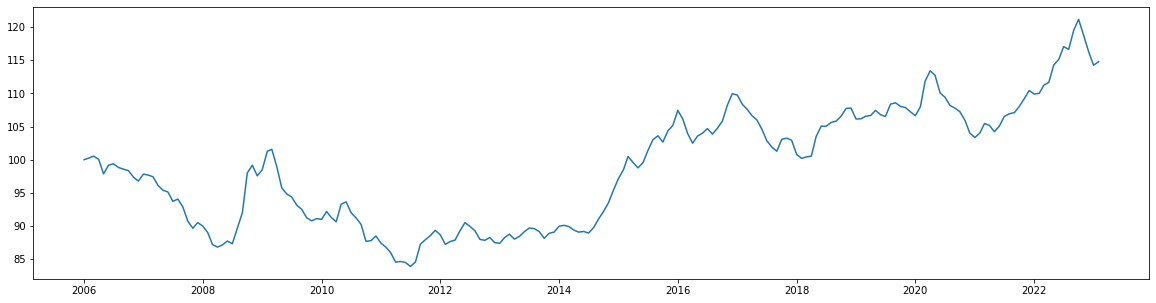

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: GJnF7 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/GJnF7/


{'data': {'publicId': 'GJnF7',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'GJnF7',
  'type': 'd3-lines',
  'title': 'Real Broad Dollar Index',
  'lastEditStep': 5,
  'publishedAt': '2023-03-04T00:27:52.719Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/GJnF7/2/',
  'publicVersion': 2,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/RTWEXBGS.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'Board of Governors of the Federal Reserve System (US)',
    'source-url': 'https://fred.stlouisfed.org/series/RTWEXBGS',
    'intro': 'Index Jan 2006=100, Not Seasonally Adjusted',
    'byline': 'UFM Market Trends',
    'ari

In [114]:
series = "RTWEXBGS"
chart_title = "Real Broad Dollar Index"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "GJnF7"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Index Jan 2006=100, Not Seasonally Adjusted", 
                                  byline="UFM Market Trends", 
                                  source_name="Board of Governors of the Federal Reserve System (US)",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

## Balance on Current Account, NIPA'**s**

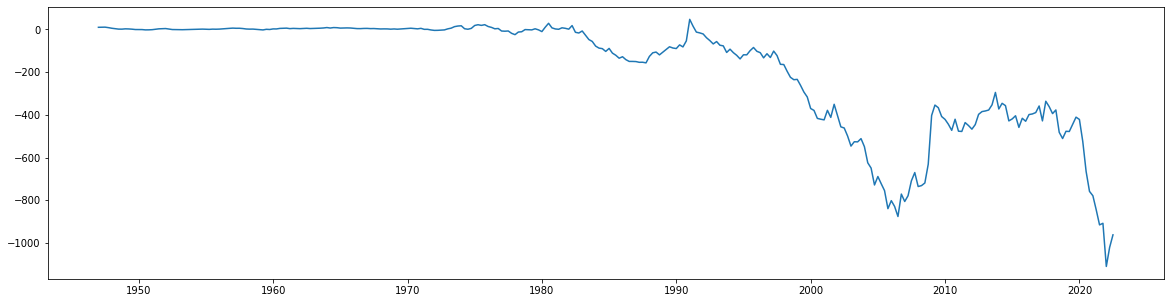

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: YMDLO 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/YMDLO/


{'data': {'publicId': 'YMDLO',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': 'YMDLO',
  'type': 'd3-lines',
  'title': "Balance on Current Account, NIPA's",
  'lastEditStep': 5,
  'publishedAt': '2023-03-04T00:35:55.579Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/YMDLO/2/',
  'publicVersion': 2,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/NETFI.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'U.S. Bureau of Economic Analysis',
    'source-url': 'https://fred.stlouisfed.org/series/NETFI',
    'intro': 'Billions of Dollars, Seasonally Adjusted Annual Rate',
    'byline': 'UFM Market Trends',
    'aria-descr

In [116]:
series = "NETFI"
chart_title = "Balance on Current Account, NIPA's"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "YMDLO"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Billions of Dollars, Seasonally Adjusted Annual Rate", 
                                  byline="UFM Market Trends", 
                                  source_name="U.S. Bureau of Economic Analysis",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

## Net International Investment Position (NIIP)

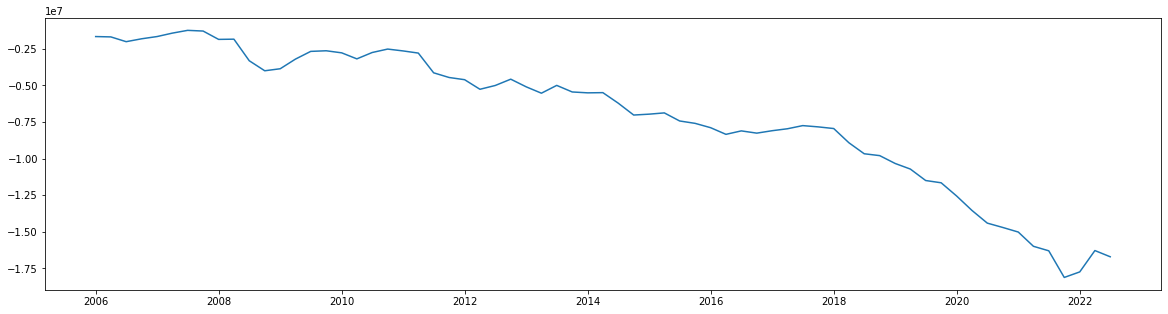

Upload complete
https://console.cloud.google.com/storage/browser?project=ufm-market-trends

****** CHART ID: 7DSUF 


**********
Response: 200
{'Response: 200'}
Sharing url: https://www.datawrapper.de/_/7DSUF/


{'data': {'publicId': '7DSUF',
  'language': 'en-US',
  'theme': 'datawrapper-data',
  'id': '7DSUF',
  'type': 'd3-lines',
  'title': 'U.S. Net International Investment Position',
  'lastEditStep': 5,
  'publishedAt': '2023-03-04T00:45:00.551Z',
  'publicUrl': 'https://datawrapper.dwcdn.net/7DSUF/3/',
  'publicVersion': 3,
  'deleted': False,
  'deletedAt': None,
  'forkable': False,
  'isFork': False,
  'metadata': {'data': {'changes': [],
    'transpose': False,
    'vertical-header': True,
    'horizontal-header': True,
    'column-format': {'values': {'number-divisor': 0}},
    'external-data': 'https://storage.googleapis.com/ufm-market-trends/united-states/fred/IIPUSNETIQ.csv',
    'upload-method': 'external-data',
    'use-datawrapper-cdn': True},
   'describe': {'source-name': 'Millions of Dollars, Not Seasonally Adjusted',
    'source-url': 'https://fred.stlouisfed.org/series/IIPUSNETIQ',
    'intro': 'Millions of Dollars, Not Seasonally Adjusted',
    'byline': 'UFM Market Tr

In [119]:
series = "IIPUSNETIQ"
chart_title = "U.S. Net International Investment Position"

process_fred_series(series_name=series,
                    k_periods=6000,
                    function_to_apply= lambda values: values,
                    bar=False)

# Comment this two lines after first time
# response_object = create_datawrapper_chart(chart_title, type_="d3-lines")
# chart_id = response_object["publicId"]

chart_id = "7DSUF"
print(f"\n****** CHART ID: {chart_id}", "\n\n\n**********")

set_datawrapper_chart_properties(chart_id=chart_id, 
                                  title=chart_title, 
                                  chart_type="d3-lines", 
                                  external_data=f"https://storage.googleapis.com/ufm-market-trends/united-states/fred/{series}.csv",
                                  intro="Millions of Dollars, Not Seasonally Adjusted", 
                                  byline="UFM Market Trends", 
                                  source_name="Millions of Dollars, Not Seasonally Adjusted",
                                  source_url=f"https://fred.stlouisfed.org/series/{series}",
                                  y_grid_format="",
                                  number_divisor=0, chart_height=300)

publish_datawrapper_chart(chart_id)

## US Dollar Holdings By Foreign Central Banks